In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import pickle
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from catboost import CatBoostClassifier
from category_encoders import BinaryEncoder, TargetEncoder
from datetime import datetime
from lime import lime_tabular
from scipy import stats
from scipy.stats import randint, loguniform, uniform, chi2_contingency
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, accuracy_score, precision_score, recall_score
)
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer, LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTENC

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0. Data Loading and inspection

In [ ]:
df_uncleaned = pd.read_csv("investments_VC.csv", encoding='ISO-8859-1')

In [ ]:
print("Investments shape is: ", df_uncleaned.shape)

# Last row with data manually insepcted is 49.439 so there are a lot of rows read as NaN´s which have no data

Investments shape is:  (54294, 39)


In [ ]:
df_uncleaned.head(5)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_uncleaned.info()

# Funding total usd is read as object instead of float/int, also data columns are not the right data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

In [ ]:
duplicates_count = df_uncleaned['permalink'].duplicated(keep=False).sum()
print(f"Number of duplicated entries in 'permalink' column: {duplicates_count}")
# High number of duplicates come from a lot of empty rows, which we need to drop

Number of duplicated entries in 'permalink' column: 4860


### Analysing part of target column "Status"

Our target column is complicated. The goal is to predict whether a start-up is successful or not. For this we rely on classification. One part of the final target column will be the column "Status". Therefore we begin by taking a quick deep dive into it to understand the data better.

In [ ]:
status_counts = df_uncleaned['status'].value_counts(dropna=False)

check = len(df_uncleaned) - status_counts.get('acquired', 0) - status_counts.get('closed', 0) - status_counts.get('operating', 0)

missing_values = df_uncleaned["status"].isna().sum()

other = check - missing_values

print(f"There are {status_counts.get('acquired', 0)} acquired companies")
print(f"There are {status_counts.get('closed', 0)} closed companies")
print(f"There are {status_counts.get('operating', 0)} operating companies")
print(f"There are {missing_values} NaN values")
print(f"There are {other} other values")

There are 3692 acquired companies
There are 2603 closed companies
There are 41829 operating companies
There are 6170 NaN values
There are 0 other values


Insights: We have a overrepresentation of operating companies. We have a low amount of closed companies. This indicates that the model will most likely overly predict Start-ups as successful whether than unsuccessful. 

# 1. Data Cleaning

### 1.0 Modeling disclaimer / Limitations

In the development of this model, a significant number of data values were dropped and extensive feature engineering was conducted to refine the input dataset and improve the performance of the model.

Under normal circumstances, to comprehensively understand the impact of these actions, it would be necessary to develop and evaluate models both before and after these modifications. Such a comparative analysis would ideally involve handling the full dataset with over 30 columns, requiring the encoding of numerous categorical features. This process significantly increases the dimensionality of the data.

However, due to the substantial increase in computational power and resources required to manage this heightened dimensionality, we made a deliberate decision to forgo this part of the analysis. While this decision allows us to proceed within the practical constraints of our current resources, it is important to acknowledge that skipping this step prevents us from fully evaluating the effects of our data preprocessing decisions on the model's performance.

### 1.1 Deleting unnecessary columns

To reduce unnecessary and redundant data, we delete columns that are not relevant for model development.
We want to remove post_ipo_equity and post_ipo_debt as well since this it´s not interesting to us, as we are only looking at Start-ups.
We want to exclude debt_financing since this distorts the result, as debt financing is not necessarily a good prediction for success and we focus on venture capital which is generally considered as equity investment.

In [ ]:
df_clean = df_uncleaned.copy()

In [ ]:
df_clean = df_clean.drop(["permalink", "homepage_url", "post_ipo_equity", "post_ipo_debt", "debt_financing"], axis=1)

### 1.2 Cleaning columns

We start with cleaning our data. As we observed our dataset we encountered some issues. We saw that "funding_total_usd" has the wrong format. We also saw that some column names are not trimmed. 

In [ ]:
# Ensure column names are trimmed
df_clean.columns = df_clean.columns.str.strip()

# Directly convert 'funding_total_usd' to a float, thereby also transforming "-" to NaN
df_clean['funding_total_usd'] = pd.to_numeric(df_clean['funding_total_usd'].str.replace(',', ''), errors='coerce')

df_clean["funding_total_usd"].dtype

df_clean.head(5)


,name,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,#waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,&TV Communications,|Games|,Games,4000000.0,operating,USA,CA,Los Angeles,Los Angeles,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Rock' Your Paper,|Publishing|Education|,Publishing,40000.0,operating,EST,NaN,Tallinn,Tallinn,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(In)Touch Network,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,NaN,London,London,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-R- Ranch and Mine,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Since some column names have the wrong format, we fix it
df_clean.rename(columns={' market ': 'market', ' funding_total_usd ': 'funding_total_usd'}, inplace=True)

In [ ]:
# Turning all of our Date Columns into pd.datetime, to ensure consistency and the right data type 
df_clean['founded_at'] =  pd.to_datetime(df_clean['founded_at'], format='%Y-%m-%d', errors = 'coerce')
df_clean['first_funding_at'] =  pd.to_datetime(df_clean['first_funding_at'], format='%Y-%m-%d', errors = 'coerce')
df_clean['last_funding_at'] =  pd.to_datetime(df_clean['last_funding_at'], format='%Y-%m-%d', errors = 'coerce')
df_clean['founded_year'] =  pd.to_datetime(df_clean['founded_year'], format='%Y', errors = 'coerce')
df_clean['founded_month'] =  pd.to_datetime(df_clean['founded_month'], format='%Y-%m', errors = 'coerce')

In [ ]:
# Cleaning the Market column, since it has unnecessary spaces
df_clean['market'] = df_clean['market'].str.strip()

### 1.3 Check and drop NaN

In the beginning of our analysis, we will first examine all potential missing data across variables to identify any underlying patterns. This preliminary step ensures that our data handling strategies are informed and effective.

                                    Column  Missing Values  \
state_code                      state_code           24133   
founded_quarter            founded_quarter           15812   
founded_month                founded_month           15812   
founded_year                  founded_year           15812   
founded_at                      founded_at           15741   
funding_total_usd        funding_total_usd           13387   
city                                  city           10972   
country_code                  country_code           10129   
region                              region           10129   
market                              market            8824   
category_list                category_list            8817   
status                              status            6170   
first_funding_at          first_funding_at            4866   
last_funding_at            last_funding_at            4862   
name                                  name            4857   
secondar

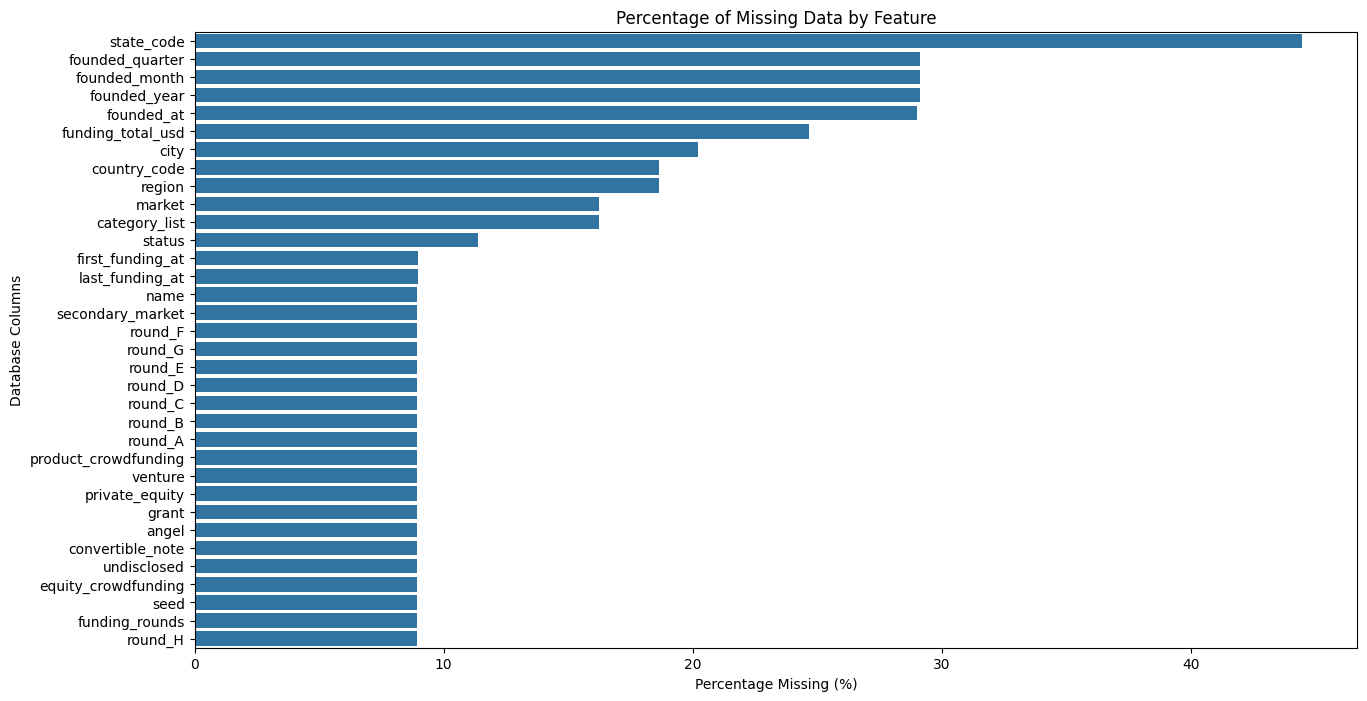

In [ ]:
# Calculate the number of missing values for each column in df_clean
missing_counts = df_clean.isnull().sum()

# Calculate the percentage of missing values for each column
missing_percentage = (missing_counts / len(df_clean)) * 100

# Create a DataFrame to analyze missing data
missing_data = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing Values': missing_counts,
    'Percentage Missing (%)': missing_percentage
}).sort_values(by='Percentage Missing (%)', ascending=False)

print(missing_data)

plt.figure(figsize=(15, 8))
sns.barplot(x='Percentage Missing (%)', y='Column', data=missing_data)
plt.title('Percentage of Missing Data by Feature')
plt.xlabel('Percentage Missing (%)')
plt.ylabel('Database Columns')
plt.show()

### **Key Observations**

#### Highly Missing Data
State Code: Has the highest number of missing values at 12,192, suggesting many entries may lack this information, possibly due to non-U.S. entries or incomplete records.
Funding Total USD and City: Also have a significant number of missing values (5,694 and 3,132 respectively), impacting analyses dependent on geographical and funding insights.

#### Moderate Missing Data
Country Code and Region: Both have 2,755 missing entries, which could hinder geographic segmentation or market analysis.
Market and Category List: Each missing 1,567 and 1,562 values respectively, potentially affecting industry-specific analyses.

#### Minimal or No Missing Data
Columns related to funding rounds (e.g., Round_A, Round_B), and operational metrics (e.g., Seed, Grant) show no missing data, suggesting well-maintained or mandatory fields.

#### **Interpretation and Implications**

#### Geographic Data Gaps
Significant missing values in State Code, City, Country Code, and Region imply challenges in performing detailed geographical analysis. This may be due to the dataset including global companies where such information is not uniformly available. However, this will pose no problem to our analysis, since we are building geographical features later in part 3 based on an additional datasets.

#### Market and Category Gaps
Missing data in market and category_list may impede specific industry or market-specific studies, as understanding the segments these companies operate in would be limited. Also this will not be a proble for our analsis, because we later on build a feature based on industry mapping on the given market data and do not use categeory data, because in venture capital only inudstry has a dsigiifcant impact.

#### Market and Category Gaps
Missing data in market and category_list may impede specific industry or market-specific studies, as understanding the segments these companies operate in would be limited. Also this will not be a proble for our analsis, because we later on build a feature based on industry mapping on the given market data and do not use categeory data, because in venture capital only inudstry has a dsigiifcant impact.

#### Funding Gaps
One of the columns with the most missing data is 'Funding Total USD.' This is likely because these startups did not receive funding, which is quite normal, considering that venture capital is a highly selective industry, and only a small percentage of startups secure funding.

As explained above, a key variable for analysis is the "status" column, which is essential for constructing the target variable. Rows with an empty status value are unusable and can be discarded. For other columns, particularly those related to funding rounds (e.g., Pre-Seed, Seed, Series A), we need to fill them with zeros rather than dropping them. This is because an empty value in a funding-related column does not necessarily mean we have to discard the row. As these rounds follow a chronological sequence, a startup might raise a Pre-Seed round and not proceed to raise any more rounds.

### 1.4 Checking "year" column

In [ ]:
df_clean["founded_year"].dtypes

dtype('<M8[ns]')

In [ ]:
df_clean["founded_year"].isna().sum()

15812

### Imputation of `founded_year` Using KNNImputer

#### Choosing Imputation Over Dropping Values
In our dataset, the `founded_year` column contains more than 10,000 missing entries. Dropping such a significant number of records could result in a substantial loss of data and potentially bias the analysis. Imputing these values, especially since they represent years, is sensible as it preserves the dataset's integrity and size.

#### Why KNN Imputer?
We use `KNNImputer` because it allows for estimating missing years by considering the similarity between entries. This method assumes that companies founded around similar times may exhibit similar characteristics in other attributes, making KNN a practical choice for filling in missing years.

#### Data Preparation and Imputation Process
Before imputation, the `founded_year` must be converted from datetime to integer format to comply with `KNNImputer`'s requirements. We then use `KNNImputer` to fill missing values based on the nearest neighbors, ensuring our data remains robust for further analysis.


In [ ]:
if not pd.api.types.is_datetime64_any_dtype(df_clean['founded_year']):
    df_clean['founded_year'] = pd.to_datetime(df_clean['founded_year'], errors='coerce', format='%Y')

# Check if there are any non-conversible values that caused 'coerce' to produce NaT
print("After conversion, null values:", df_clean['founded_year'].isnull().sum())

#Convert datetime to integer year
df_clean['founded_year'] = df_clean['founded_year'].dt.year

# Initialize the KNN imputer and impute
imputer = KNNImputer(n_neighbors=5, weights="uniform")
founded_year_imputed = imputer.fit_transform(df_clean[['founded_year']].astype(float))

# Replace the original 'founded_year' column with the imputed values
df_clean['founded_year'] = founded_year_imputed.round()  # Round to get integer year values

# Check the imputation
print("Null values after imputation:", df_clean['founded_year'].isnull().sum())


After conversion, null values: 15812
Null values after imputation: 0


In [ ]:
# Since status is part of our target variable, has a lot of important information and cannot be properly imputed, we will drop all NaN´s in this column
df_clean = df_clean.dropna(subset=["status"])

print("Number of NaN: ", df_clean["status"].isna().sum())

Number of NaN:  0


In [ ]:
df_clean[['convertible_note', 'angel', 'grant', 'private_equity',
       'secondary_market', 'product_crowdfunding', 'round_A','round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G','round_H']].fillna(0)

,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49434,0.0,0.0,0.0,0.0,0.0,0.0,1587301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49435,25873.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.5 Check for outliers

In the outlier detection part, we first focus on generating an overview of the numerical variables within our dataset, which are primarily those related to funding rounds. We employ box plots to visually identify outliers across these key metrics. Given the diverse nature of funding data, where outliers may represent either errors or legitimate extreme values, we apply domain-specific knowledge to discern their nature. This approach ensures a tailored handling of outliers—either removing or adjusting them based on their relevance and impact on our analysis. This careful consideration helps in maintaining the integrity of our dataset and enhances the robustness of our predictive models.

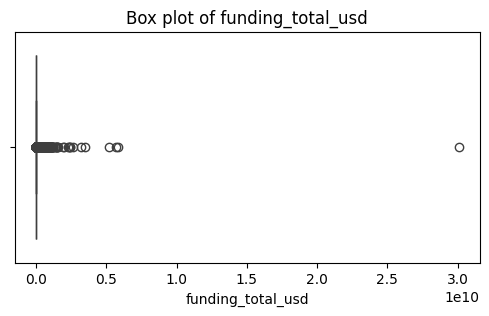

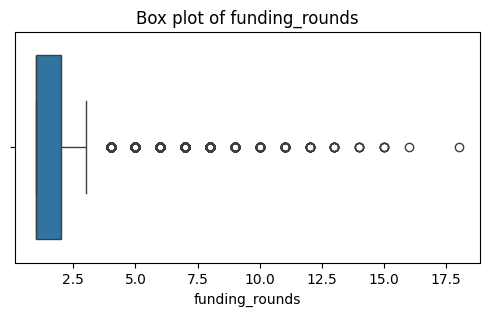

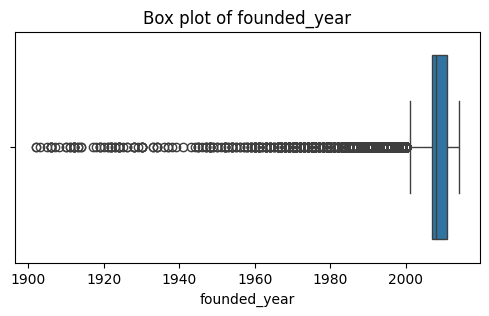

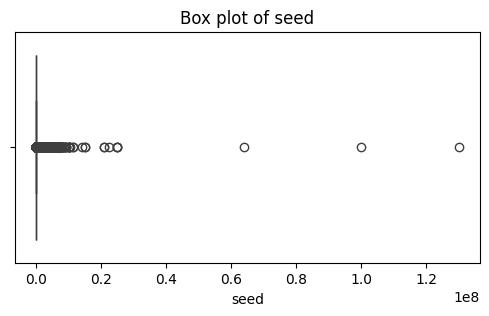

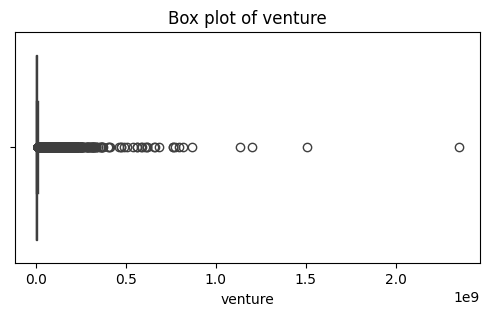

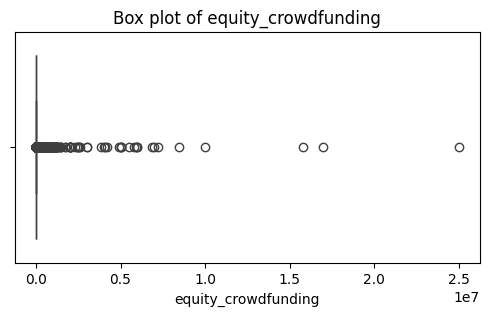

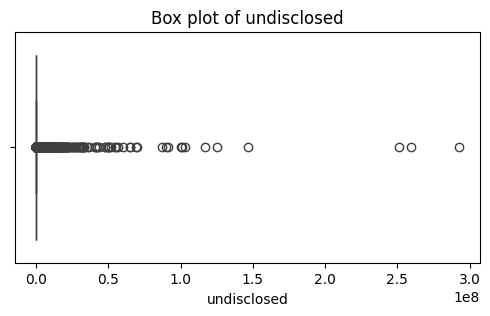

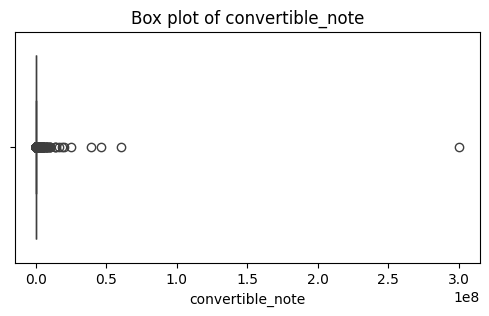

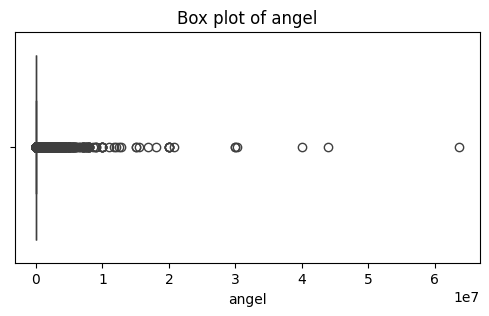

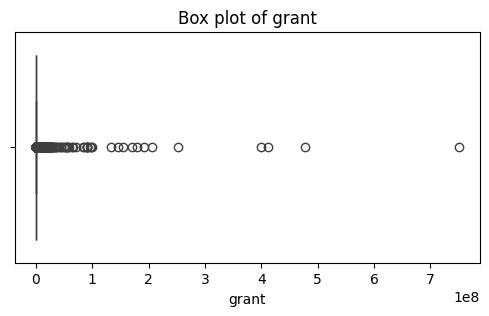

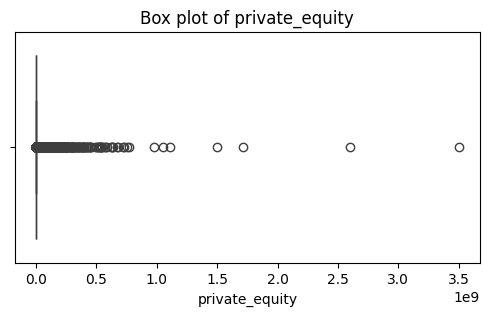

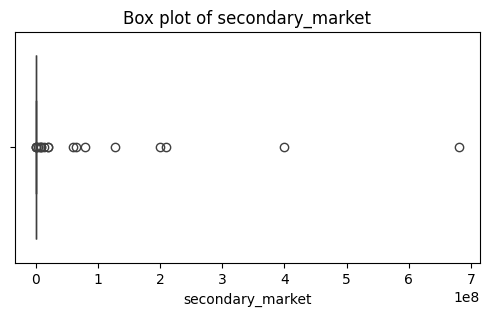

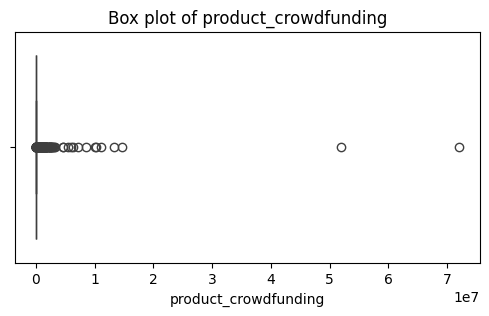

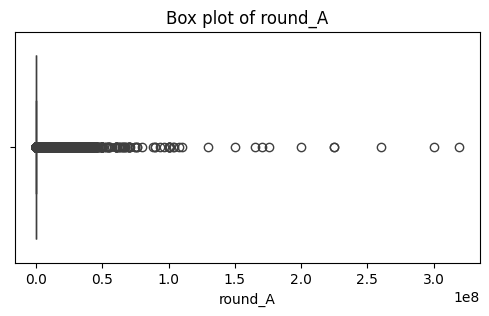

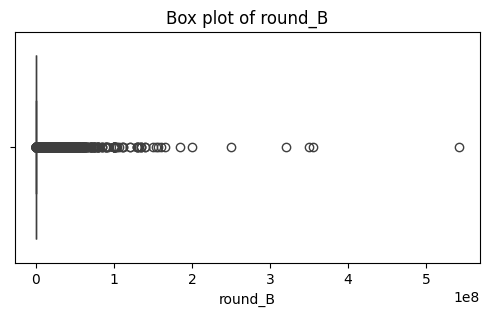

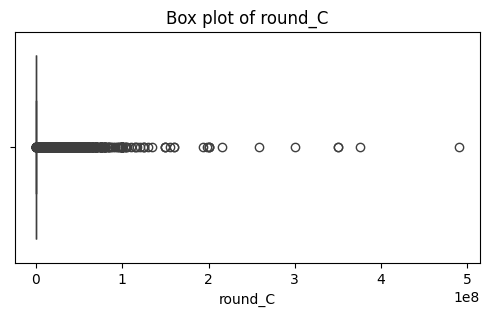

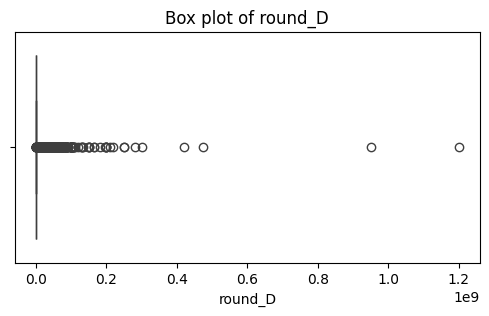

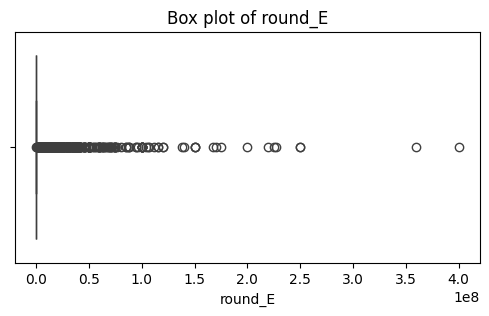

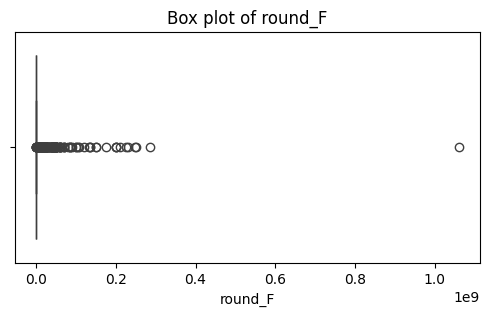

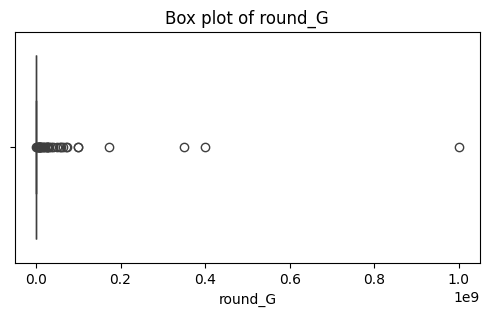

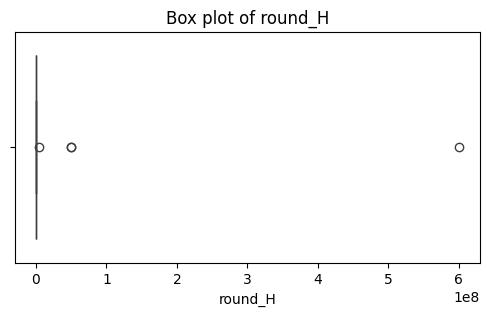

In [ ]:
# Filter out non-numeric columns if necessary
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64'])

# Plot box plots for each numeric variable
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_clean[col])
    plt.title(f'Box plot of {col}')
    plt.show()


The box plots generated show a significant skewness in the distribution of these funding metrics. The visualization indicates that the majority of the data points are concentrated at lower values with a long tail extending towards higher values, suggesting outliers and extreme values. This extreme skewness can affect the accuracy of our predictive models. Therefore, we will examine each variable individually to understand the underlying factors contributing to this skewness and implement appropriate transformations or techniques to normalize the data. This methodical scrutiny ensures that our models are built on robust and well-conditioned data.

#1: Funding Related Features

In [ ]:
cutoffs = {
    'equity_crowdfunding': 3e6,  # $2 million
    'product_crowdfunding': 3e6,  # $2 million
    'undisclosed': 20e6,  # $15 million
    'venture': 50e6,  # $50 million
    'grant': 5e6,  # $5 million
    'private_equity': 300e6,  # $250 million
    'secondary_market': 100e6,  # $50 million
    'convertible_note': 5e6,  # $5 million
    'angel': 5e6,  # $5 million
    'seed': 10e6,  # $10 million
    'round_A': 20e6,  # $20 million
    'round_B': 30e6,  # $30 million
    'round_C': 40e6,  # $40 million
    'round_D': 60e6,  # $60 million
    'round_E': 80e6,  # $80 million
    'round_F': 100e6,  # $100 million
}

original_data_count = df_clean.shape[0]

# Applying the updated cutoff thresholds and updating the dataframe
for funding_type, cutoff in cutoffs.items():
    df_clean = df_clean[df_clean[funding_type] <= cutoff]

print(f"Original Data: {original_data_count} rows")
print(f"Data shape after removing high funding outliers: {df_clean.shape}")

Original Data: 48124 rows
Data shape after removing high funding outliers: (45702, 34)


Seed, Angel, and Early Rounds (A, B, C): We’ve set cutoffs for these initial funding stages based on our team’s hands-on experience in the industry. Our previous work has shown us that these stages typically see smaller investment amounts. By choosing thresholds that reflect common funding ranges, we aim to keep our dataset grounded in the most typical scenarios, avoiding the distortion that rare mega-deals might cause.

Later Rounds (D, E, F): As startups grow and enter these later stages, they naturally need bigger investments to scale up operations or pursue aggressive expansion plans. The higher cutoffs we’ve set for these rounds are also rooted in our team’s deep understanding of what’s typical and necessary for companies at this maturity level. These thresholds help us capture significant business activities without letting a few outsized rounds skew the overall picture.

Specialized Funding Types (Private Equity, Equity Crowdfunding, etc.): The dynamics here can be quite varied, depending on the industry and investment specifics. Our cutoffs for these types of funding are crafted to balance inclusivity with realism, ensuring we capture a broad spectrum of normal activities while excluding outlier data that could mislead our analysis. This careful balance comes from our team’s extensive experience with different investment mechanisms.

These thoughtfully set thresholds ensure that our analysis remains relevant and true to real-world conditions. By aligning our dataset closely with industry norms and leveraging our team’s domain expertise, we enhance the reliability and applicability of our insights, providing a solid foundation for understanding investment trends and growth patterns in the startup ecosystem.

In the following we will check for outliers in the amount of funding rounds.

In [ ]:
# Outlier analysis for funding_rounds
Q1_funding_rounds = df_clean['funding_rounds'].quantile(0.25)
Q3_funding_rounds = df_clean['funding_rounds'].quantile(0.75)
IQR_funding_rounds = Q3_funding_rounds - Q1_funding_rounds

# Define outliers as those beyond 1.5 times the IQR from the Q1 and Q3
outliers_IQR_funding_rounds = df_clean[(df_clean['funding_rounds'] < (Q1_funding_rounds - 1.5 * IQR_funding_rounds)) | (df_clean['funding_rounds'] > (Q3_funding_rounds + 1.5 * IQR_funding_rounds))]

# Calculate Z-scores to identify outliers
z_scores_funding_rounds = np.abs(stats.zscore(df_clean['funding_rounds']))
outliers_Z_funding_rounds = df_clean[z_scores_funding_rounds > 3]

# Display the number of outliers detected by each method
outliers_IQR_count_funding_rounds = outliers_IQR_funding_rounds.shape[0]
outliers_Z_count_funding_rounds = outliers_Z_funding_rounds.shape[0]

# Print the number of outliers detected by each method
print(f"Number of outliers detected by the IQR method: {outliers_IQR_count_funding_rounds}")
print(f"Number of outliers detected by the Z-score method: {outliers_Z_count_funding_rounds}")


Number of outliers detected by the IQR method: 2950
Number of outliers detected by the Z-score method: 1343


/tmp/ipykernel_178/2262696459.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=funding_rounds_counts.index, y=funding_rounds_counts.values, palette='viridis')


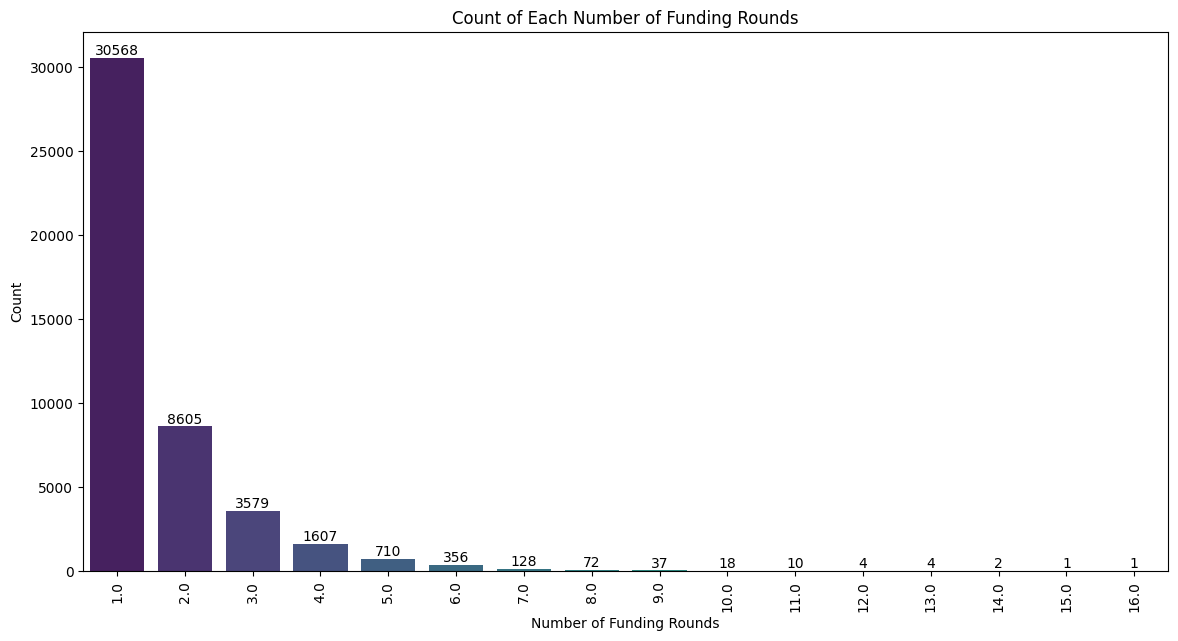

In [ ]:
funding_rounds_counts = df_clean['funding_rounds'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(14, 7))
sns.barplot(x=funding_rounds_counts.index, y=funding_rounds_counts.values, palette='viridis')

# Annotate the bars with the exact counts
for i, count in enumerate(funding_rounds_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Count of Each Number of Funding Rounds')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate the x labels if they overlap
plt.show()


As the IQR would delete many outliers that are necessary for our model (e.g. it would mainly focus on very few rounds), we will only drop every entries that have more than 10 rounds. In venture capital, exceeding 10 funding rounds is unusual and typically indicates prolonged profitability challenges or significant capital needs, which are atypical of normal investment cycles. By capping funding rounds at 10, we ensure our dataset reflects standard venture funding patterns, enhancing our model’s relevance and predictive accuracy. This approach helps maintain focus on typical investment trajectories, avoiding skew from exceptional cases.

In [ ]:
print("Data shape before removing funding rounds outliers:", df_clean.shape)
df_clean = df_clean[df_clean['funding_rounds'] <= 10]
print("Data shape after removing funding rounds outliers:", df_clean.shape)

Data shape before removing funding rounds outliers: (45702, 34)
Data shape after removing funding rounds outliers: (45680, 34)


#2 Time related Features

<AxesSubplot: xlabel='founded_year', ylabel='Count'>

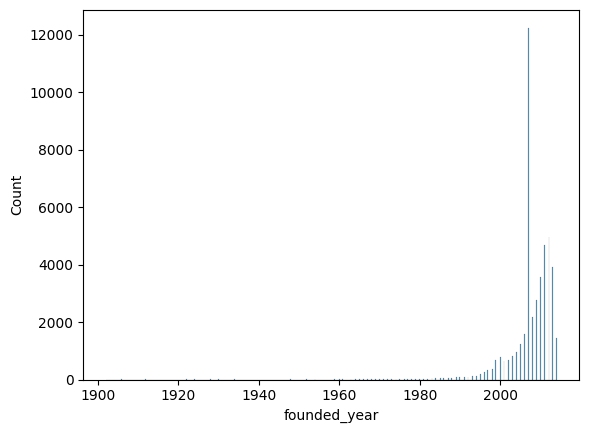

In [ ]:
import seaborn as sns
sns.histplot(df_clean['founded_year'].dropna(), kde=False)

In [ ]:
# Print data shape before removing
print("Data shape before removing years before 1990:", df_clean.shape)

# Filtering the DataFrame to remove rows where 'founded_year' is before 1990
df_clean = df_clean[df_clean['founded_year'] >= 1990]

# Print data shape after removing
print("Data shape after removing years before 1990:", df_clean.shape)


Data shape before removing years before 1990: (45680, 34)
Data shape after removing years before 1990: (44831, 34)


<AxesSubplot: xlabel='founded_year', ylabel='Count'>

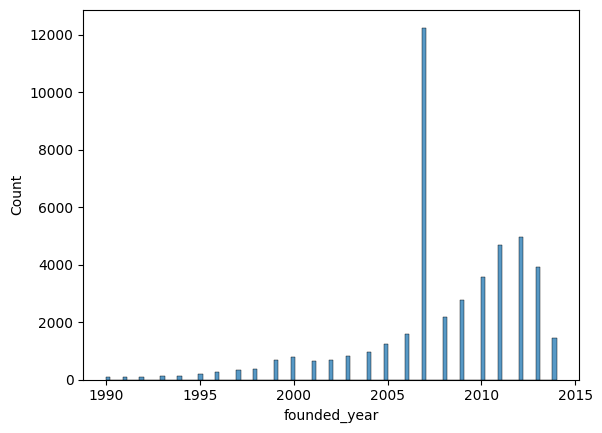

In [ ]:
sns.histplot(df_clean['founded_year'].dropna(), kde=False)

In analyzing startup data, the founded_year helps assess company maturity. Extremely old founding years might not only skew analyses but also represent entities not reflective of current entrepreneurial trends and market dynamics. Using Interquartile Range (IQR) and Z-score methods, we identify and remove these outliers. This ensures our dataset remains focused on entities relevant to today's business environment, enhancing the reliability and relevance of our findings by excluding atypical or outdated companies.

Now we will check if the other time-related columns still have outlier (specially focusing on lower outliers)

In [ ]:
def calculate_datetime_outliers(df, column_name):
    # Convert datetime to ordinal
    df[column_name + '_ordinal'] = df[column_name].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Compute Q1, Q3, and IQR
    Q1 = df[column_name + '_ordinal'].quantile(0.25)
    Q3 = df[column_name + '_ordinal'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers using IQR
    lower_outliers_IQR_count = df[df[column_name + '_ordinal'] < lower_bound].shape[0]
    upper_outliers_IQR_count = df[df[column_name + '_ordinal'] > upper_bound].shape[0]
    
    # Count outliers using Z-scores
    z_scores = np.abs(stats.zscore(df[column_name + '_ordinal'].dropna()))
    outliers_Z_count = np.sum(z_scores > 3)

    print(f"Lower outliers count for {column_name} (IQR method): {lower_outliers_IQR_count}")
    print(f"Upper outliers count for {column_name} (IQR method): {upper_outliers_IQR_count}")
    print(f"Outliers count for {column_name} (Z-score method): {outliers_Z_count}")

# Applying the function to each column
datetime_columns = ['founded_at', 'founded_month', 'first_funding_at', 'last_funding_at']
for column in datetime_columns:
    if column in df_clean.columns:
        calculate_datetime_outliers(df_clean, column)

Lower outliers count for founded_at (IQR method): 1343
Upper outliers count for founded_at (IQR method): 0
Outliers count for founded_at (Z-score method): 44
Lower outliers count for founded_month (IQR method): 1621
Upper outliers count for founded_month (IQR method): 0
Outliers count for founded_month (Z-score method): 501
Lower outliers count for first_funding_at (IQR method): 737
Upper outliers count for first_funding_at (IQR method): 0
Outliers count for first_funding_at (Z-score method): 509
Lower outliers count for last_funding_at (IQR method): 1069
Upper outliers count for last_funding_at (IQR method): 0
Outliers count for last_funding_at (Z-score method): 420


After already having dropped the outliers for funding_year before, we use z-scores for dropping outliers in datetime data to provide a statistically rigorous approach that considers the distribution of the data and effectively handles extreme values.

In [ ]:
# Drop outliers for datetime columns using z-score

def drop_datetime_outliers(df, column_name, z_threshold=3):
    # Convert datetime to ordinal
    df[column_name + '_ordinal'] = df[column_name].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Calculate z-scores
    z_scores = np.abs(stats.zscore(df[column_name + '_ordinal'].dropna()))
    
    # Find outliers based on z-score threshold
    outliers_indices = np.where(z_scores > z_threshold)[0]
    
    # Drop rows with outliers
    df.drop(df.index[outliers_indices], inplace=True)
    
    # Calculate and display number of rows dropped
    num_rows_dropped = len(outliers_indices)
    print(f"Number of rows dropped for {column_name}: {num_rows_dropped}")

# Display shape before dropping outliers (overall)
print(f"Shape before dropping outliers (overall): {df_clean.shape}")

# Applying the function to each datetime column
datetime_columns = ['founded_at', 'founded_month', 'first_funding_at', 'last_funding_at']
for column in datetime_columns:
    if column in df_clean.columns:
        drop_datetime_outliers(df_clean, column)

# Display shape after dropping outliers (overall)
print(f"Shape after dropping outliers (overall): {df_clean.shape}")


Shape before dropping outliers (overall): (44831, 38)
Number of rows dropped for founded_at: 44
Number of rows dropped for founded_month: 501
Number of rows dropped for first_funding_at: 499
Number of rows dropped for last_funding_at: 421
Shape after dropping outliers (overall): (43366, 38)


In [ ]:
# Distribution of numerical columns after outlier analysis to check, if all still have values in them
numerical_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
print("Distribution of numerical features:\n")
df_clean[numerical_columns].describe().T

Distribution of numerical features:



,count,mean,std,min,25%,50%,75%,max
funding_total_usd,35492.0,8.463641e+06,6.331199e+07,1.0,300000.0,1574756.0,7000000.0,5.800000e+09
funding_rounds,43366.0,1.593783e+00,1.087778e+00,1.0,1.0,1.0,2.0,1.000000e+01
founded_year,43366.0,2.008073e+03,4.195233e+00,1990.0,2007.0,2008.0,2011.0,2.014000e+03
seed,43366.0,2.154217e+05,6.383244e+05,0.0,0.0,0.0,40000.0,1.000000e+07
venture,43366.0,3.918040e+06,8.241743e+06,0.0,0.0,0.0,3679879.0,5.000000e+07
equity_crowdfunding,43366.0,2.999695e+03,5.834878e+04,0.0,0.0,0.0,0.0,3.000000e+06
undisclosed,43366.0,5.007025e+04,6.654791e+05,0.0,0.0,0.0,0.0,2.000000e+07
convertible_note,43366.0,9.134188e+03,1.364353e+05,0.0,0.0,0.0,0.0,5.000000e+06
angel,43366.0,4.986743e+04,2.884507e+05,0.0,0.0,0.0,0.0,5.000000e+06
grant,43366.0,1.436427e+04,1.913134e+05,0.0,0.0,0.0,0.0,5.000000e+06


In [ ]:
# As round_H now is empty (also makes sense at it also almost never occurs in real-life), we will now drop this column
df_clean.drop('round_H', axis=1, inplace=True)

# 2. Exploratory Data Analysis

### 2.1 Distribution of categorical and numerical columns

We start by looking at the distribution of categorical and numerical variables. We want to visualize the distributions. 

In [ ]:
# Frequencies and categories in categorical columns
categorical_columns = df_clean.select_dtypes(include=['object']).columns
print("Frequencies of categorical features:\n")
df_clean[categorical_columns].describe().T

Frequencies of categorical features:



,count,unique,top,freq
name,43365,43291,Roost,4
category_list,40062,15230,|Software|,3280
market,40055,745,Software,4159
status,43366,3,operating,37765
country_code,38619,115,USA,24960
state_code,26153,61,CA,8489
region,38619,1058,SF Bay Area,5819
city,37888,3898,San Francisco,2330
founded_quarter,33563,100,2012-Q1,2667


Market Concentration:
Most Common Market: The 'Software' market is the predominant category, encompassing 11.1% of entries, highlighting a significant focus on software-related ventures within the dataset.
Company Status:
Operating Status: A vast majority of companies (37,765 out of 43,366) are still operating, suggesting low rates of closure or failure.
Geographical Distribution:
Country and State: The USA, specifically California (CA), dominates the geographical landscape of the dataset. This indicates a heavy concentration of companies in the United States, particularly in a state known for its vibrant startup ecosystem.
City and Region: San Francisco in the SF Bay Area is the most represented city and region, which aligns with California's known status as a tech hub, especially for new ventures and startups.
Company Foundation:
Founded Quarter: Most companies were founded in '2012-Q1', suggesting a significant founding activity during this period. This could correlate with economic cycles or industry trends at the time.

In [ ]:
# Distribution of numerical columns
numerical_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
print("Distribution of numerical features:\n")
df_clean[numerical_columns].describe().T

Distribution of numerical features:



,count,mean,std,min,25%,50%,75%,max
funding_total_usd,35492.0,8.463641e+06,6.331199e+07,1.0,300000.0,1574756.0,7000000.0,5.800000e+09
funding_rounds,43366.0,1.593783e+00,1.087778e+00,1.0,1.0,1.0,2.0,1.000000e+01
founded_year,43366.0,2.008073e+03,4.195233e+00,1990.0,2007.0,2008.0,2011.0,2.014000e+03
seed,43366.0,2.154217e+05,6.383244e+05,0.0,0.0,0.0,40000.0,1.000000e+07
venture,43366.0,3.918040e+06,8.241743e+06,0.0,0.0,0.0,3679879.0,5.000000e+07
equity_crowdfunding,43366.0,2.999695e+03,5.834878e+04,0.0,0.0,0.0,0.0,3.000000e+06
undisclosed,43366.0,5.007025e+04,6.654791e+05,0.0,0.0,0.0,0.0,2.000000e+07
convertible_note,43366.0,9.134188e+03,1.364353e+05,0.0,0.0,0.0,0.0,5.000000e+06
angel,43366.0,4.986743e+04,2.884507e+05,0.0,0.0,0.0,0.0,5.000000e+06
grant,43366.0,1.436427e+04,1.913134e+05,0.0,0.0,0.0,0.0,5.000000e+06


Funding Dynamics:
Total Funding: The funding_total_usd spans a vast range, from a minimum of $1 to a maximum of $5,800,000,000 reflecting a substantial disparity in the amount of funding companies receive.
Funding Rounds: Companies have between 1 and 10 funding rounds, with a median of 2 rounds, indicating that most companies do not proceed beyond the initial stages of funding.
Company Longevity:
Years of Operation: The founded_year ranges from 1990 to 2014, with a mean year of 2007. This suggests that the majority of companies in the dataset are relatively young, emphasizing the dataset's focus on newer businesses.
Investment Types:
Venture Funding: Averages around $3,918,040 with significant variability, indicating that venture capital is a primary source of funding with wide-ranging investment amounts.
Seed Funding: Typically smaller amounts, indicating its role in early-stage support for businesses.
Private Equity and Grants: Show high variability, which can be attributed to their sporadic use across different sectors and business models.
Funding Over Time:
Date Ordinals: The first_funding_at_ordinal and last_funding_at_ordinal suggest that most funding activity concentrates closer to the company's founding date. This could be indicative of a high initial funding need followed by a period of lesser external funding reliance.

### 2.2 Correlation Analysis

Next we want to investigate the correlation between our different variables to gain insights on importance.

We will use Pearson correlation for analyzing this dataset because the assumptions for applying this method are satisfactorily met. Firstly, preliminary outlier analysis has been conducted, ensuring that extreme values are identified and appropriately managed, thus mitigating their impact on the correlation results. Additionally, the variables of interest—such as funding rounds and amounts—are continuous and typically show a linear relationship, as investments in earlier stages might influence subsequent funding amounts. These variables are also on a ratio scale, where the intervals and ratios between values are meaningful. Although the exact normality of the data distribution was not verified, the large sample size of the dataset helps, as Pearson correlation tends to be robust to normality deviations in large datasets. This makes Pearson a suitable choice for initial exploration of linear relationships in our venture capital data.

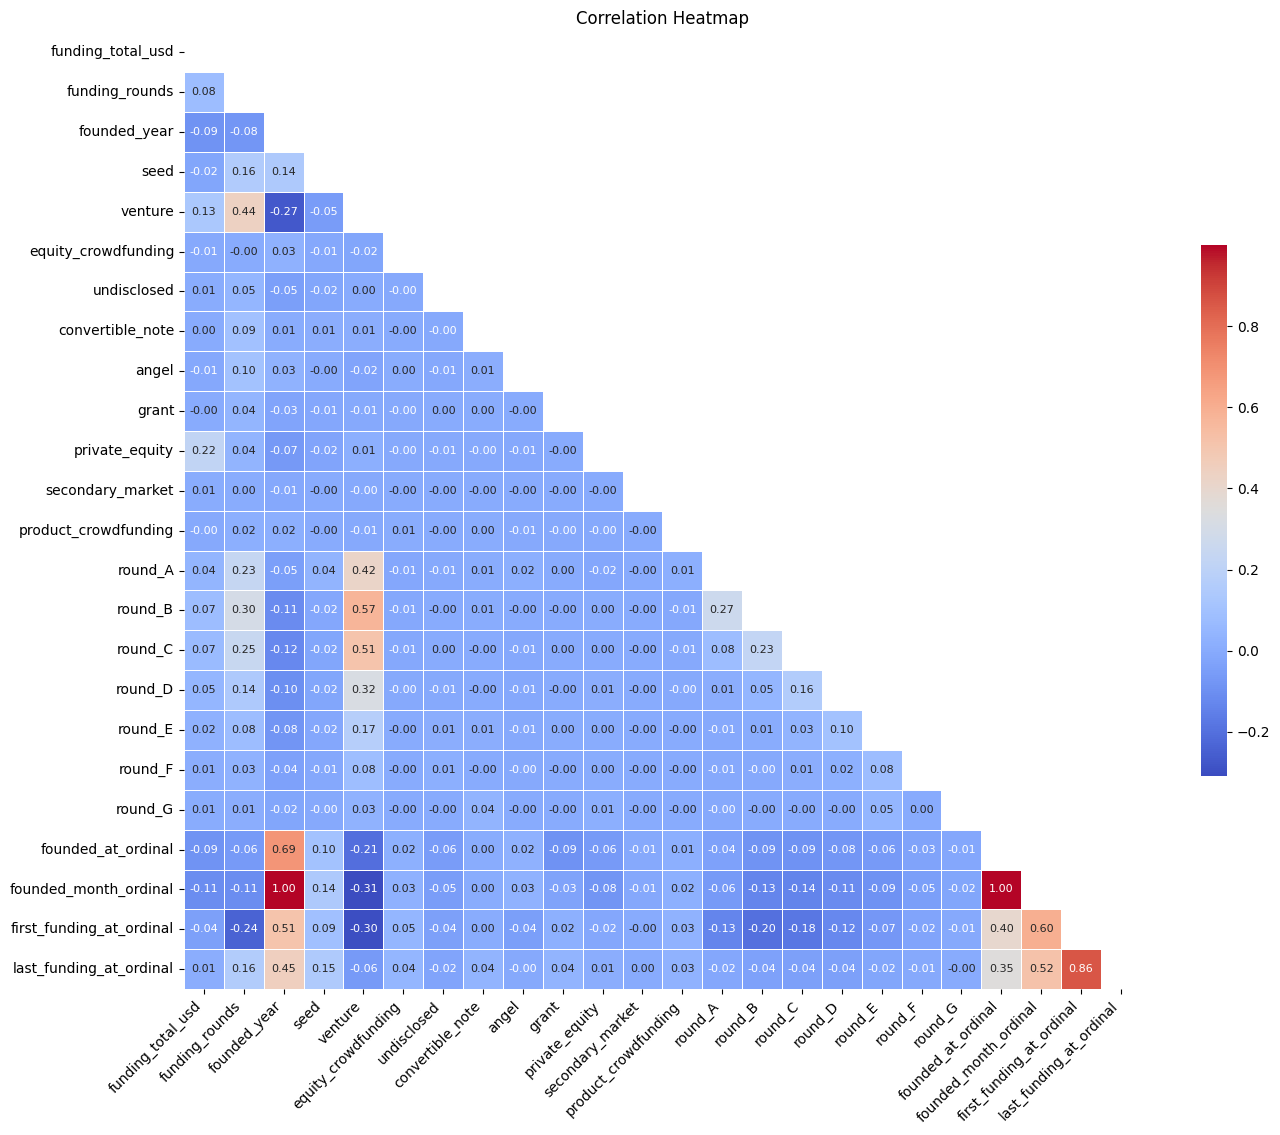

In [ ]:
# Calculate the correlation matrix
corr_matrix = df_clean.select_dtypes(include=['int64', 'float64']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot_kws={"size": 8})

# Other customizations
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap')

# Show plot with adjustments
plt.tight_layout() 
plt.show()

Strong Correlations with 'first_funding_at_ordinal':
founded_at_ordinal (0.69): There is a strong correlation between when a company was founded and when it received its first funding. This suggests that companies often secure their first funding relatively soon after being established.
last_funding_at_ordinal (0.64): There's a strong correlation between the first and last funding events, which indicates that the time span from first to last funding is typically compact.
Round-specific Funding Correlations:
round_B with round_A (0.42): This notable correlation suggests that companies receiving a Series A are likely to proceed to a Series B.
round_C with round_B (0.51): Indicates a progression in funding rounds, with a good likelihood of moving from Series B to Series C.
round_C with round_A (0.25): Shows a moderate correlation, suggesting that companies that start with Series A funding are somewhat likely to reach Series C.
Correlation with Total Funding (funding_total_usd):
Moderate correlations with round_B (0.57) and round_C (0.51): This suggests that the later funding rounds, specifically Series B and C, contribute significantly to the total funding raised.
Date Variables:
founded_month_ordinal (1.00): Shows a perfect correlation with founded_at_ordinal, indicating a direct and consistent relationship between the two date representations.
Last Funding Time:
last_funding_at_ordinal shows strong correlations with round_A (0.45) and round_B (0.45): This indicates that the timing of the last funding round is likely influenced by the initial funding rounds, specifically the first and second.
Independence of Some Variables:
Private equity and secondary market show very low or no correlations with other funding rounds, suggesting that these types of funding operate independently of typical venture capital stages.

##  2.3 Deep dive into variable "Status" (Part of target variable)

We first want to visualize the distribution of the "Status" column. As it will be part of the target variable and we are therefore interested in its distribution and relationship with other variables of interest.

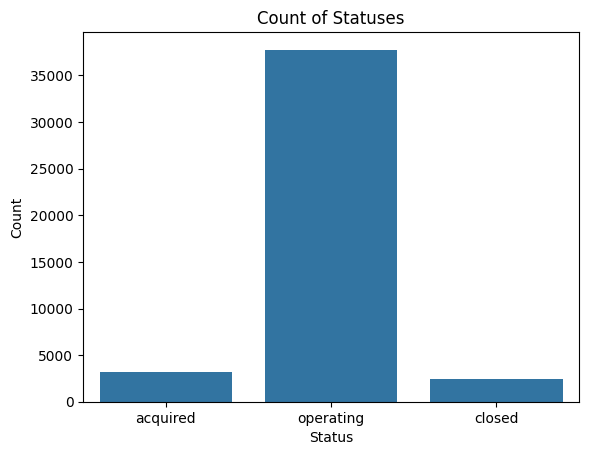

In [ ]:
sns.countplot(x='status', data=df_clean)

plt.title('Count of Statuses')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

Explanation:
We can clearly see that operating status makes the largest chunk in this dataset - therefore we need deeper look into operating status

Now we will analyse the impact of funding_rounds and status.

In [ ]:
grouped = df_clean.groupby("status")["round_A"].count()

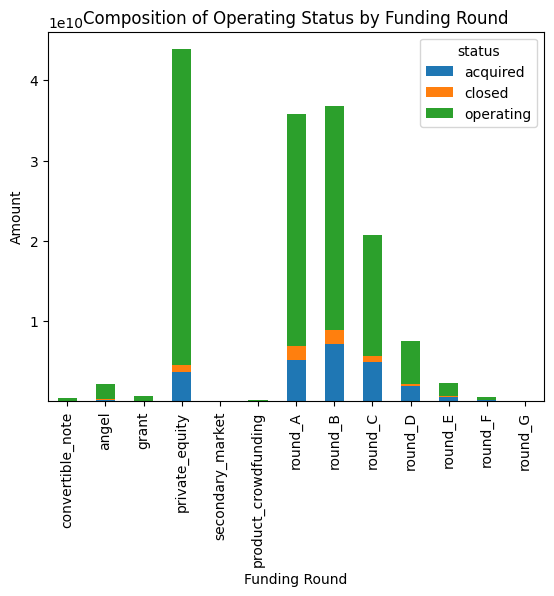

In [ ]:
# First, group by 'status' and sum all the funding rounds
grouped = df_clean.groupby('status')[['convertible_note',
       'angel', 'grant', 'private_equity',
       'secondary_market', 'product_crowdfunding', 'round_A',
       'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G']].sum()

# Now plot a stacked bar chart
grouped.transpose().plot(kind='bar', stacked=True)

plt.title('Composition of Operating Status by Funding Round')
plt.xlabel('Funding Round')
plt.ylabel('Amount')

plt.show()

Obervation: We can see that the majority of the of funding rounds seem to be Private Equity and Series A to E. Within these operating status always makes the majority of the class. We can furthermore see that the share of closed start-ups seem to be higher in Early-Stages which makes sense, since the risk is the highest here.

### 2.4 Deep dive into funding total and rounds


A deep dive into funding totals and rounds during the EDA phase of our ML project is crucial for uncovering correlations between the amount and frequency of investments and startup success, helping to refine predictive features and enhance model accuracy.

Text(0.5, -0.01, 'Correlation coefficient: 0.08')

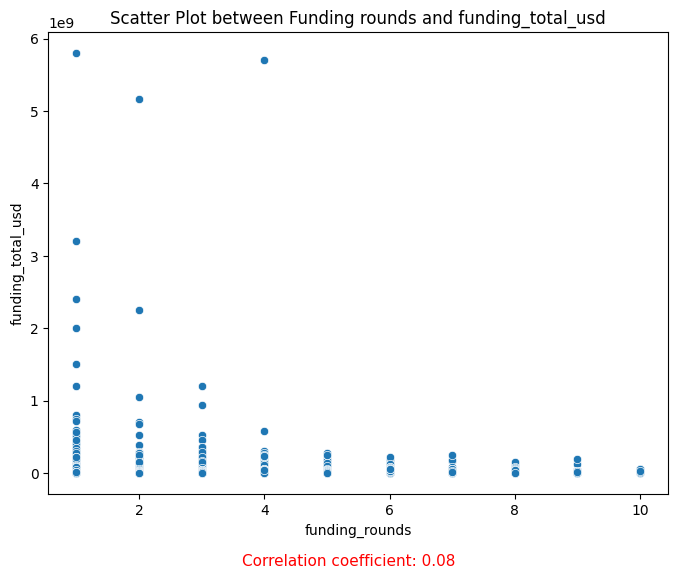

In [ ]:
corr_value = df_clean['funding_rounds'].corr(df_clean['funding_total_usd'])
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='funding_rounds', y='funding_total_usd')
plt.title('Scatter Plot between Funding rounds and funding_total_usd')
plt.figtext(0.5, -0.01, f'Correlation coefficient: {corr_value:.2f}', ha="center", fontsize=11, color="red")


Observation: There seems to be a low correlation between funding rounds and total funding. It seems that the funding amount per round if you have less rounds is comparably higher.

### 2.4 Geographical insights

 Next we want to investigate the countries present in our dataset. We expect US to be most represented since it has the biggest Start-up ecosystem.

In [ ]:
df_clean['country_code'].nunique()

115

In [ ]:
# Show percentages of countries in the dataset
total_companies = df_clean['name'].nunique()

country_company_counts = df_clean.groupby('country_code')['name'].nunique().sort_values(ascending=False)

country_company_percentages = (country_company_counts / total_companies) * 100

top_10_country_percentages = country_company_percentages.head(10)
print(top_10_country_percentages)

country_code
USA    57.580097
GBR     5.453789
CAN     2.834307
CHN     2.381557
DEU     2.011966
FRA     1.824860
IND     1.760181
ISR     1.466818
ESP     1.148045
ITA     0.672195
Name: name, dtype: float64


The percentage distribution of countries in the dataset, where the USA dominates with over 57%, can heavily bias the model towards American market trends and practices, potentially reducing its accuracy and applicability in other regions. Countries like Germany, France, and China are underrepresented, making the model less effective at capturing and generalizing the unique factors driving startup success in these diverse economic and regulatory environments. To enhance global applicability, it's crucial to either balance the dataset geographically or adapt the model to reflect regional specifics in its predictions. We can furthermore check the relationship between funding total and country.

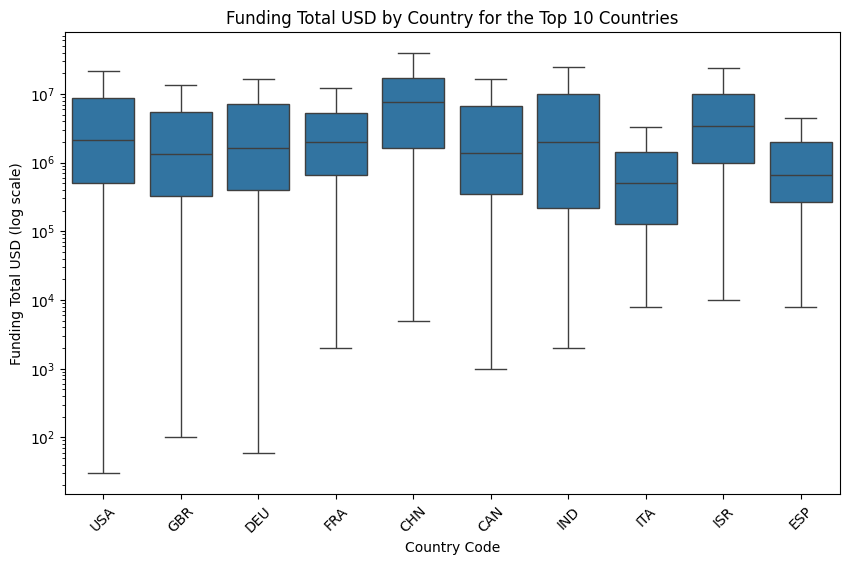

In [ ]:
# Top 10 countries by the number of unique companies
top_10_countries = df_clean['country_code'].value_counts().head(10).index.tolist()

# Filter the df to include only entries from these top 10 countries
top_countries_df = df_clean[df_clean['country_code'].isin(top_10_countries)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=top_countries_df, x='country_code', y='funding_total_usd', showfliers=False)
plt.xticks(rotation=45)
plt.title('Funding Total USD by Country for the Top 10 Countries')
plt.xlabel('Country Code')
plt.ylabel('Funding Total USD (log scale)')
plt.yscale('log') 

plt.show()

We observe that while the median funding across the top 10 countries doesn't vary dramatically, there are differences in funding distribution and range. The United States (USA) and Germany (DEU) exhibit the widest interquartile ranges, suggesting more variability in funding amounts within these countries. China (CHN), on the other hand, shows a higher median funding level compared to others, implying that the typical funding amount there is comparatively greater. 

In [ ]:
print(df_clean['region'].unique())
print(df_clean['region'].nunique())

['New York City' 'Los Angeles' 'Tallinn' ... 'Jodhpur' 'Muenchen'
 'Buckinghamshire']
1058


There is 1058 different regions in the dataset.

In [ ]:
df_clean.groupby('region')['name'].count().sort_values(ascending = False).head(10) # Top 10 regions

region
SF Bay Area         5819
New York City       2311
Boston              1527
London              1413
Los Angeles         1225
Seattle              815
Washington, D.C.     685
Chicago              637
San Diego            576
Denver               559
Name: name, dtype: int64

Most of the companies come from the SF Bay Area followed by NYC, Boston, London and Los Angeles, which is expected, but also here leads to a potential bias towards specific regions in the model.

### 2.5 Deep dive into markets and funding

To investigate the importance of different markets inside our data we look into the number of investments per market.

In [ ]:
df_clean['market'].nunique()

745

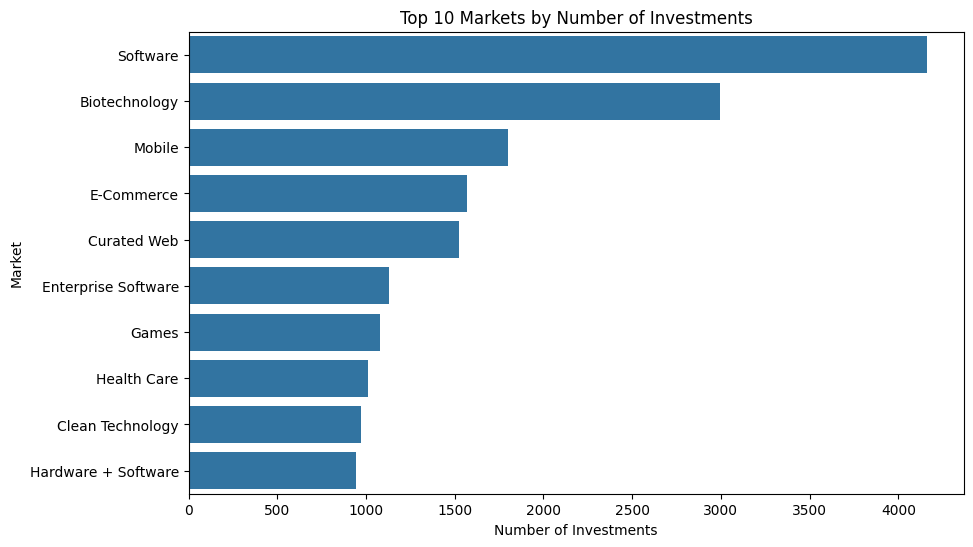

In [ ]:
# Top 10 markets by the number of investments
top_markets = df_clean['market'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_markets.values, y=top_markets.index)
plt.title('Top 10 Markets by Number of Investments')
plt.xlabel('Number of Investments')
plt.ylabel('Market')
plt.show()


The top 10 markets by number of investments highlight that the Software sector leads significantly, followed by Biotechnology and Mobile. The dominance of the Software industry, with over 3000 investments, indicates a strong investor preference and potential for high innovation and scalability in this sector. In contrast, sectors like Social Media and Hardware + Software receive considerably fewer investments, suggesting either market saturation or higher barriers to entry. This distribution of investments can inform venture capitalists about trending industries and potential areas for investment diversification. As the number of investments might not reflect the importance of this industry, we will also have a look at the funding for these markets.

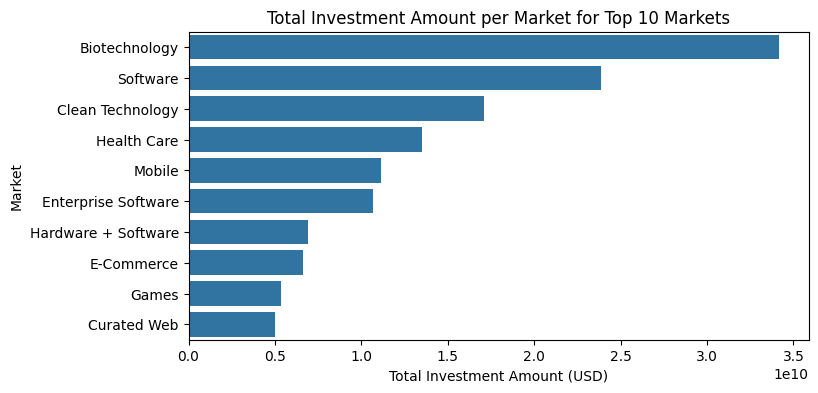

In [ ]:
top_markets = df_clean['market'].value_counts().head(10).index

# Filter the DataFrame for rows where the market is in top_markets
top_markets_df = df_clean[df_clean['market'].isin(top_markets)]

# Group by market and sum the funding_total_usd, then sort in descending order
market_investment_totals = top_markets_df.groupby('market')['funding_total_usd'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=market_investment_totals.values, y=market_investment_totals.index)
plt.title('Total Investment Amount per Market for Top 10 Markets')
plt.xlabel('Total Investment Amount (USD)')
plt.ylabel('Market')
plt.show()

This deep-dive is revealing that Biotechnology leads with the highest funding, surpassing even the Software industry. Despite Software having a higher number of investments, the amount invested in Biotechnology indicates its capital-intensive nature and the high costs associated with R&D in this sector. This significant investment disparity underscores the differing financial dynamics across markets, with sectors like Mobile and Enterprise Software also showing substantial funding levels, reflecting their importance and growth potential in the current economic landscape, potentially important for the model.

### 2.6 Distribution of years in the dataset

Time series analysis is important for the model because it allows for the examination of trends and patterns in startup funding over time, which are critical for understanding market dynamics and predicting future activities. This type of analysis helps identify periods of growth or decline, economic cycles, and the impact of external factors on startup investment.

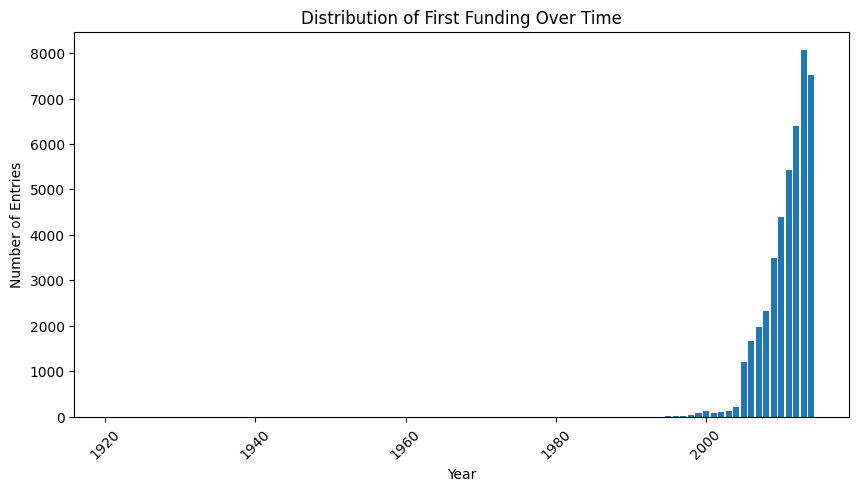

In [ ]:
# Convert 'first_funding_at' to datetime format
df_clean['first_funding_at_datetime'] = pd.to_datetime(df_clean['first_funding_at'])

# Extract the year from the 'first_funding_at_datetime' column
df_clean['first_funding_at_year'] = df_clean['first_funding_at_datetime'].dt.year

# Count entries per year for first funding
first_funding_yearly_counts = df_clean['first_funding_at_year'].value_counts().sort_index()

# Plotting first funding dates distribution
plt.figure(figsize=(10, 5))
plt.bar(first_funding_yearly_counts.index, first_funding_yearly_counts.values) 
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Distribution of First Funding Over Time')
plt.xticks(rotation=45) 
plt.show()



The first funding instances over time show a dramatic increase in the number of startups receiving their initial funding from the 1980s onward, with a significant surge post-2000. This trend is particularly pronounced in the 2010s, reflecting a booming interest in startup investment and the increasing availability of venture capital. Analyzing this trend is crucial for the model as it provides historical context that can help predict future funding patterns and identify periods of high economic activity or potential market saturation, which are essential for making informed investment decisions.

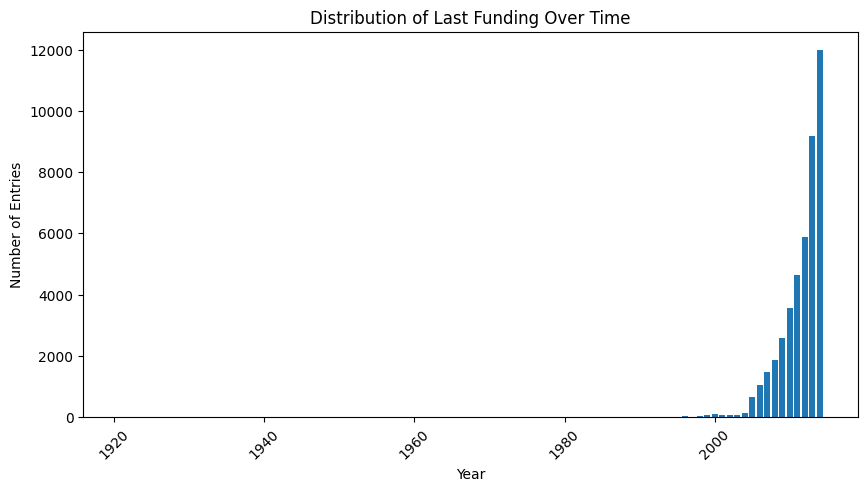

In [ ]:
# Convert 'last_funding_at' to datetime format
df_clean['last_funding_at_datetime'] = pd.to_datetime(df_clean['last_funding_at'])

# Extract the year from the 'first_funding_at_datetime' column
df_clean['last_funding_at_year'] = df_clean['last_funding_at_datetime'].dt.year

# Count entries per year
yearly_counts = df_clean['last_funding_at_year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(yearly_counts.index, yearly_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Distribution of Last Funding Over Time')
plt.xticks(rotation=45)
plt.show()


The same trends and patterns can be observed for last funding over time.


Next, the distribution of company founding dates is crucial for our exploratory data analysis as it provides insights into the historical context of startup activity, relevant to our predictive model

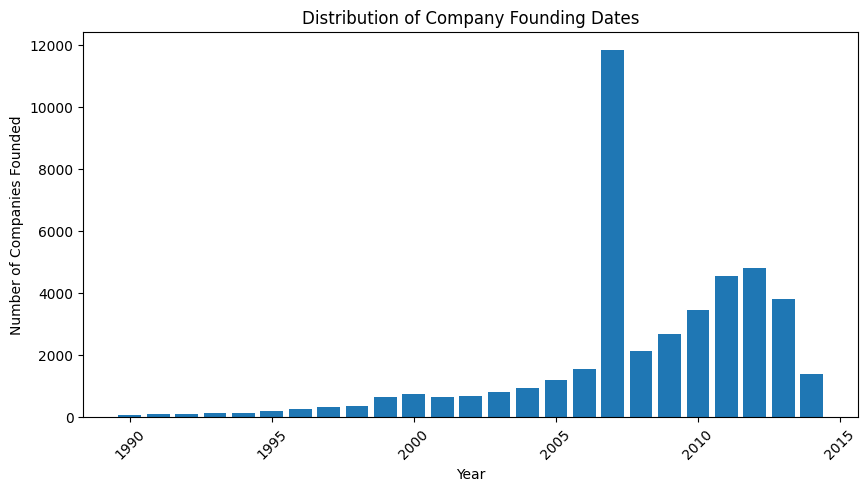

In [ ]:
# Count entries per year
yearly_counts = df_clean['founded_year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(yearly_counts.index, yearly_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Companies Founded')
plt.title('Distribution of Company Founding Dates')
plt.xticks(rotation=45)  
plt.show()

We can see a surge in startups from 2000 to 2012, with a peak around 2010 (ignoring the imputation process and therefore the outlier) , that may indicate periods of high innovation and economic recovery conducive to startup success, suggesting these years could be strong predictors of potential success in our model. The subsequent decline post-2012 could influence the model's risk assessment, indicating a cooling period in startup formation which might correlate with higher failure rates or lower market entry. Understanding these trends helps in refining the model to better predict success by considering when a company was founded as a significant feature.

The EDA for our target will follow (in 3.9) after feature engineering and building the target variable. 

# 3. Feature engineering

After we cleaned our dataset and got a better understanding of our underlying data using EDA, we can start with Feature Engineering.

In [ ]:
df_features = df_clean.copy()

### 3.1 Industry Mapping

In our group project, the process of mapping countries into continents and markets into industries represents an application of feature aggregation. This technique is commonly used in data preprocessing for several reasons:

Data Reduction: By reducing the granularity from countries to continents or markets to industries, we are effectively lowering the number of categorical levels, thereby decreasing the feature space. This simplification can lead to models that are less complex, require less computational resources, and are less prone to overfitting.

Stabilization of Data: Data at a more aggregated level tends to exhibit less variability, which can be advantageous in modelling. High variability can sometimes obscure underlying patterns, particularly when dealing with noisy or sparse datasets. 

To be complient with Crunchbase handling of their industries we apply the Crunchbase industry mapping to our dataset to use this Feature later in our prediction. 
The list was being taken from here https://support.crunchbase.com/hc/en-us/articles/360043146954-What-Industries-are-included-in-Crunchbase-

In [ ]:
# grouping markets in industries to decrease the number of segments. 
admin_services = str('Employer Benefits Programs, Human Resource Automation, Corporate IT, Distribution, Service Providers, Archiving Service, Call Center, Collection Agency, College Recruiting, Courier Service, Debt Collections, Delivery, Document Preparation, Employee Benefits, Extermination Service, Facilities Support Services, Housekeeping Service, Human Resources, Knowledge Management, Office Administration, Packaging Services, Physical Security, Project Management, Staffing Agency, Trade Shows, Virtual Workforce').split(', ')
advertising = str('Creative Industries, Promotional, Advertising Ad Exchange, Ad Network, Ad Retargeting, Ad Server, Ad Targeting, Advertising, Advertising Platforms, Affiliate Marketing, Local Advertising, Mobile Advertising, Outdoor Advertising, SEM, Social Media Advertising, Video Advertising').split(', ')
agriculture = str('Agriculture, AgTech, Animal Feed, Aquaculture, Equestrian, Farming, Forestry, Horticulture, Hydroponics, Livestock').split(', ')
app = str('Application Performance Monitoring, App Stores, Application Platforms, Enterprise Application, App Discovery, Apps, Consumer Applications, Enterprise Applications, Mobile Apps, Reading Apps, Web Apps').split(', ')
artificial_intelli = str('Artificial Intelligence, Intelligent Systems, Machine Learning, Natural Language Processing, Predictive Analytics').split(', ')
biotechnology = str('Synthetic Biology, Bio-Pharm, Bioinformatics, Biometrics, Biopharma, Biotechnology, Genetics, Life Science, Neuroscience, Quantified Self').split(', ')
clothing = str('Fashion, Laundry and Dry-cleaning, Lingerie, Shoes').split(', ')
shopping = str('Consumer Behavior, Customer Support Tools, Discounts, Reviews and Recommendations, Auctions, Classifieds, Collectibles, Consumer Reviews, Coupons, E-Commerce, E-Commerce Platforms, Flash Sale, Gift, Gift Card, Gift Exchange, Gift Registry, Group Buying, Local Shopping, Made to Order, Marketplace, Online Auctions, Personalization, Point of Sale, Price Comparison, Rental, Retail, Retail Technology, Shopping, Shopping Mall, Social Shopping, Sporting Goods, Vending and Concessions, Virtual Goods, Wholesale').split(', ')
community = str("Self Development, Sex, Forums, Match-Making, Babies, Identity, Women, Kids, Entrepreneur, Networking, Adult, Baby, Cannabis, Children, Communities, Dating, Elderly, Family, Funerals, Humanitarian, Leisure, LGBT, Lifestyle, Men's, Online Forums, Parenting, Pet, Private Social Networking, Professional Networking, Q&A, Religion, Retirement, Sex Industry, Sex Tech, Social, Social Entrepreneurship, Teenagers, Virtual World, Wedding, Women's, Young Adults").split(', ')
electronics  = str('Mac, iPod Touch, Tablets, iPad, iPhone, Computer, Consumer Electronics, Drones, Electronics, Google Glass, Mobile Devices, Nintendo, Playstation, Roku, Smart Home, Wearables, Windows Phone, Xbox').split(', ')
consumer_goods= str('Commodities, Sunglasses, Groceries, Batteries, Cars, Beauty, Comics, Consumer Goods, Cosmetics, DIY, Drones, Eyewear, Fast-Moving Consumer Goods, Flowers, Furniture, Green Consumer Goods, Handmade, Jewelry, Lingerie, Shoes, Tobacco, Toys').split(', ')
content = str('E-Books, MicroBlogging, Opinions, Blogging Platforms, Content Delivery Network, Content Discovery, Content Syndication, Creative Agency, DRM, EBooks, Journalism, News, Photo Editing, Photo Sharing, Photography, Printing, Publishing, Social Bookmarking, Video Editing, Video Streaming').split(', ')
data = str('Optimization, A/B Testing, Analytics, Application Performance Management, Artificial Intelligence, Big Data, Bioinformatics, Biometrics, Business Intelligence, Consumer Research, Data Integration, Data Mining, Data Visualization, Database, Facial Recognition, Geospatial, Image Recognition, Intelligent Systems, Location Based Services, Machine Learning, Market Research, Natural Language Processing, Predictive Analytics, Product Research, Quantified Self, Speech Recognition, Test and Measurement, Text Analytics, Usability Testing').split(', ')
design = str('Visualization, Graphics, Design, Designers, CAD, Consumer Research, Data Visualization, Fashion, Graphic Design, Human Computer Interaction, Industrial Design, Interior Design, Market Research, Mechanical Design, Product Design, Product Research, Usability Testing, UX Design, Web Design').split(', ')
education = str('Universities, College Campuses, University Students, High Schools, All Students, Colleges, Alumni, Charter Schools, College Recruiting, Continuing Education, Corporate Training, E-Learning, EdTech, Education, Edutainment, Higher Education, Language Learning, MOOC, Music Education, Personal Development, Primary Education, Secondary Education, Skill Assessment, STEM Education, Textbook, Training, Tutoring, Vocational Education').split(', ')
energy = str('Gas, Natural Gas Uses, Oil, Oil & Gas, Battery, Biofuel, Biomass Energy, Clean Energy, Electrical Distribution, Energy, Energy Efficiency, Energy Management, Energy Storage, Fossil Fuels, Fuel, Fuel Cell, Oil and Gas, Power Grid, Renewable Energy, Solar, Wind Energy').split(', ')
events = str('Concerts, Event Management, Event Promotion, Events, Nightclubs, Nightlife, Reservations, Ticketing, Wedding').split(', ')
financial = str('Debt Collecting, P2P Money Transfer, Investment Management, Trading, Accounting, Angel Investment, Asset Management, Auto Insurance, Banking, Bitcoin, Commercial Insurance, Commercial Lending, Consumer Lending, Credit, Credit Bureau, Credit Cards, Crowdfunding, Cryptocurrency, Debit Cards, Debt Collections, Finance, Financial Exchanges, Financial Services, FinTech, Fraud Detection, Funding Platform, Gift Card, Health Insurance, Hedge Funds, Impact Investing, Incubators, Insurance, InsurTech, Leasing, Lending, Life Insurance, Micro Lending, Mobile Payments, Payments, Personal Finance, Prediction Markets, Property Insurance, Real Estate Investment, Stock Exchanges, Trading Platform, Transaction Processing, Venture Capital, Virtual Currency, Wealth Management').split(', ')
food = str('Specialty Foods, Bakery, Brewing, Cannabis, Catering, Coffee, Confectionery, Cooking, Craft Beer, Dietary Supplements, Distillery, Farmers Market, Food and Beverage, Food Delivery, Food Processing, Food Trucks, Fruit, Grocery, Nutrition, Organic Food, Recipes, Restaurants, Seafood, Snack Food, Tea, Tobacco, Wine And Spirits, Winery').split(', ')
gaming = str('Game, Games, Casual Games, Console Games, Contests, Fantasy Sports, Gambling, Gamification, Gaming, MMO Games, Online Games, PC Games, Serious Games, Video Games').split(', ')
government = str('Polling, Governance, CivicTech, Government, GovTech, Law Enforcement, Military, National Security, Politics, Public Safety, Social Assistance').split(', ')
hardware= str('Cable, 3D, 3D Technology, Application Specific Integrated Circuit (ASIC), Augmented Reality, Cloud Infrastructure, Communication Hardware, Communications Infrastructure, Computer, Computer Vision, Consumer Electronics, Data Center, Data Center Automation, Data Storage, Drone Management, Drones, DSP, Electronic Design Automation (EDA), Electronics, Embedded Systems, Field-Programmable Gate Array (FPGA), Flash Storage, Google Glass, GPS, GPU, Hardware, Industrial Design, Laser, Lighting, Mechanical Design, Mobile Devices, Network Hardware, NFC, Nintendo, Optical Communication, Playstation, Private Cloud, Retail Technology, RFID, RISC, Robotics, Roku, Satellite Communication, Semiconductor, Sensor, Sex Tech, Telecommunications, Video Conferencing, Virtual Reality, Virtualization, Wearables, Windows Phone, Wireless, Xbox').split(', ')
health_care = str('Senior Health, Physicians, Electronic Health Records, Doctors, Healthcare Services, Diagnostics, Alternative Medicine, Assisted Living, Assistive Technology, Biopharma, Cannabis, Child Care, Clinical Trials, Cosmetic Surgery, Dental, Diabetes, Dietary Supplements, Elder Care, Electronic Health Record (EHR), Emergency Medicine, Employee Benefits, Fertility, First Aid, Funerals, Genetics, Health Care, Health Diagnostics, Home Health Care, Hospital, Medical, Medical Device, mHealth, Nursing and Residential Care, Nutraceutical, Nutrition, Outpatient Care, Personal Health, Pharmaceutical, Psychology, Rehabilitation, Therapeutics, Veterinary, Wellness').split(', ')
it = str('Distributors, Algorithms, ICT, M2M, Technology, Business Information Systems, CivicTech, Cloud Data Services, Cloud Management, Cloud Security, CMS, Contact Management, CRM, Cyber Security, Data Center, Data Center Automation, Data Integration, Data Mining, Data Visualization, Document Management, E-Signature, Email, GovTech, Identity Management, Information and Communications Technology (ICT), Information Services, Information Technology, Intrusion Detection, IT Infrastructure, IT Management, Management Information Systems, Messaging, Military, Network Security, Penetration Testing, Private Cloud, Reputation, Sales Automation, Scheduling, Social CRM, Spam Filtering, Technical Support, Unified Communications, Video Chat, Video Conferencing, Virtualization, VoIP').split(', ')
internet = str('Online Identity, Cyber, Portals, Web Presence Management, Domains, Tracking, Web Tools, Curated Web, Search, Cloud Computing, Cloud Data Services, Cloud Infrastructure, Cloud Management, Cloud Storage, Darknet, Domain Registrar, E-Commerce Platforms, Ediscovery, Email, Internet, Internet of Things, ISP, Location Based Services, Messaging, Music Streaming, Online Forums, Online Portals, Private Cloud, Product Search, Search Engine, SEM, Semantic Search, Semantic Web, SEO, SMS, Social Media, Social Media Management, Social Network, Unified Communications, Vertical Search, Video Chat, Video Conferencing, Visual Search, VoIP, Web Browsers, Web Hosting').split(', ')
invest = str('Angel Investment, Banking, Commercial Lending, Consumer Lending, Credit, Credit Cards, Financial Exchanges, Funding Platform, Hedge Funds, Impact Investing, Incubators, Micro Lending, Stock Exchanges, Trading Platform, Venture Capital').split(', ')
manufacturing = str('Innovation Engineering, Civil Engineers, Heavy Industry, Engineering Firms, Systems, 3D Printing, Advanced Materials, Foundries, Industrial, Industrial Automation, Industrial Engineering, Industrial Manufacturing, Machinery Manufacturing, Manufacturing, Paper Manufacturing, Plastics and Rubber Manufacturing, Textiles, Wood Processing').split(', ')
media = str('Writers, Creative, Television, Entertainment, Media, Advice, Animation, Art, Audio, Audiobooks, Blogging Platforms, Broadcasting, Celebrity, Concerts, Content, Content Creators, Content Discovery, Content Syndication, Creative Agency, Digital Entertainment, Digital Media, DRM, EBooks, Edutainment, Event Management, Event Promotion, Events, Film, Film Distribution, Film Production, Guides, In-Flight Entertainment, Independent Music, Internet Radio, Journalism, Media and Entertainment, Motion Capture, Music, Music Education, Music Label, Music Streaming, Music Venues, Musical Instruments, News, Nightclubs, Nightlife, Performing Arts, Photo Editing, Photo Sharing, Photography, Podcast, Printing, Publishing, Reservations, Social Media, Social News, Theatre, Ticketing, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming, Virtual World').split(', ')
message = str('Unifed Communications, Chat, Email, Meeting Software, Messaging, SMS, Unified Communications, Video Chat, Video Conferencing, VoIP, Wired Telecommunications').split(', ')
mobile = str('Android, Google Glass, iOS, mHealth, Mobile, Mobile Apps, Mobile Devices, Mobile Payments, Windows Phone, Wireless').split(', ')
music = str('Audio, Audiobooks, Independent Music, Internet Radio, Music, Music Education, Music Label, Music Streaming, Musical Instruments, Podcast').split(', ')
resource = str('Biofuel, Biomass Energy, Fossil Fuels, Mineral, Mining, Mining Technology, Natural Resources, Oil and Gas, Precious Metals, Solar, Timber, Water, Wind Energy').split(', ')
navigation = str('Maps, Geospatial, GPS, Indoor Positioning, Location Based Services, Mapping Services, Navigation').split(', ')
other = str('Mass Customization, Monetization, Testing, Subscription Businesses, Mobility, Incentives, Peer-to-Peer, Nonprofits, Alumni, Association, B2B, B2C, Blockchain, Charity, Collaboration, Collaborative Consumption, Commercial, Consumer, Crowdsourcing, Customer Service, Desktop Apps, Emerging Markets, Enterprise, Ethereum, Franchise, Freemium, Generation Y, Generation Z, Homeless Shelter, Infrastructure, Knowledge Management, LGBT Millennials, Non Profit, Peer to Peer, Professional Services, Project Management, Real Time, Retirement, Service Industry, Sharing Economy, Small and Medium Businesses, Social Bookmarking, Social Impact, Subscription Service, Technical Support, Underserved Children, Universities').split(', ')
payment = str('Billing, Bitcoin, Credit Cards, Cryptocurrency, Debit Cards, Fraud Detection, Mobile Payments, Payments, Transaction Processing, Virtual Currency').split(', ')
platforms = str('Development Platforms, Android, Facebook, Google, Google Glass, iOS, Linux, macOS, Nintendo, Operating Systems, Playstation, Roku, Tizen, Twitter, WebOS, Windows, Windows Phone, Xbox').split(', ')
privacy = str('Digital Rights Management, Personal Data, Cloud Security, Corrections Facilities, Cyber Security, DRM, E-Signature, Fraud Detection, Homeland Security, Identity Management, Intrusion Detection, Law Enforcement, Network Security, Penetration Testing, Physical Security, Privacy, Security').split(', ')
services = str('Funeral Industry, English-Speaking, Spas, Plumbers, Service Industries, Staffing Firms, Translation, Career Management, Business Services, Services, Accounting, Business Development, Career Planning, Compliance, Consulting, Customer Service, Employment, Environmental Consulting, Field Support, Freelance, Intellectual Property, Innovation Management, Legal, Legal Tech, Management Consulting, Outsourcing, Professional Networking, Quality Assurance, Recruiting, Risk Management, Social Recruiting, Translation Service').split(', ')
realestate= str('Office Space, Self Storage, Brokers, Storage, Home Owners, Self Storage , Realtors, Home & Garden, Utilities, Home Automation, Architecture, Building Maintenance, Building Material, Commercial Real Estate, Construction, Coworking, Facility Management, Fast-Moving Consumer Goods, Green Building, Home and Garden, Home Decor, Home Improvement, Home Renovation, Home Services, Interior Design, Janitorial Service, Landscaping, Property Development, Property Management, Real Estate, Real Estate Investment, Rental Property, Residential, Self-Storage, Smart Building, Smart Cities, Smart Home, Timeshare, Vacation Rental').split(', ')
sales = str('Advertising, Affiliate Marketing, App Discovery, App Marketing, Brand Marketing, Cause Marketing, Content Marketing, CRM, Digital Marketing, Digital Signage, Direct Marketing, Direct Sales, Email Marketing, Lead Generation, Lead Management, Local, Local Advertising, Local Business, Loyalty Programs, Marketing, Marketing Automation, Mobile Advertising, Multi-level Marketing, Outdoor Advertising, Personal Branding, Public Relations, Sales, Sales Automation, SEM, SEO, Social CRM, Social Media Advertising, Social Media Management, Social Media Marketing, Sponsorship, Video Advertising').split(', ')
science = str('Face Recognition, New Technologies, Advanced Materials, Aerospace, Artificial Intelligence, Bioinformatics, Biometrics, Biopharma, Biotechnology, Chemical, Chemical Engineering, Civil Engineering, Embedded Systems, Environmental Engineering, Human Computer Interaction, Industrial Automation, Industrial Engineering, Intelligent Systems, Laser, Life Science, Marine Technology, Mechanical Engineering, Nanotechnology, Neuroscience, Nuclear, Quantum Computing, Robotics, Semiconductor, Software Engineering, STEM Education').split(', ')
software = str('Business Productivity, 3D Technology, Android, App Discovery, Application Performance Management, Apps, Artificial Intelligence, Augmented Reality, Billing, Bitcoin, Browser Extensions, CAD, Cloud Computing, Cloud Management, CMS, Computer Vision, Consumer Applications, Consumer Software, Contact Management, CRM, Cryptocurrency, Data Center Automation, Data Integration, Data Storage, Data Visualization, Database, Developer APIs, Developer Platform, Developer Tools, Document Management, Drone Management, E-Learning, EdTech, Electronic Design Automation (EDA), Embedded Software, Embedded Systems, Enterprise Applications, Enterprise Resource Planning (ERP), Enterprise Software, Facial Recognition, File Sharing, IaaS, Image Recognition, iOS, Linux, Machine Learning, macOS, Marketing Automation, Meeting Software, Mobile Apps, Mobile Payments, MOOC, Natural Language Processing, Open Source, Operating Systems, PaaS, Predictive Analytics, Presentation Software, Presentations, Private Cloud, Productivity Tools, QR Codes, Reading Apps, Retail Technology, Robotics, SaaS, Sales Automation, Scheduling, Sex Tech, Simulation, SNS, Social CRM, Software, Software Engineering, Speech Recognition, Task Management, Text Analytics, Transaction Processing, Video Conferencing, Virtual Assistant, Virtual Currency, Virtual Desktop, Virtual Goods, Virtual Reality, Virtual World, Virtualization, Web Apps, Web Browsers, Web Development').split(', ')
sports = str('American Football, Baseball, Basketball, Boating, Cricket, Cycling, Diving, eSports, Fantasy Sports, Fitness, Golf, Hockey, Hunting, Outdoors, Racing, Recreation, Rugby, Sailing, Skiing, Soccer, Sporting Goods, Sports, Surfing, Swimming, Table Tennis, Tennis, Ultimate Frisbee, Volley Ball').split(', ')
sustainability = str('Green, Wind, Biomass Power Generation, Renewable Tech, Environmental Innovation, Renewable Energies, Clean Technology, Biofuel, Biomass Energy, Clean Energy, CleanTech, Energy Efficiency, Environmental Engineering, Green Building, Green Consumer Goods, GreenTech, Natural Resources, Organic, Pollution Control, Recycling, Renewable Energy, Solar, Sustainability, Waste Management, Water Purification, Wind Energy').split(', ')
transportation = str('Taxis, Air Transportation, Automotive, Autonomous Vehicles, Car Sharing, Courier Service, Delivery Service, Electric Vehicle, Ferry Service, Fleet Management, Food Delivery, Freight Service, Last Mile Transportation, Limousine Service, Logistics, Marine Transportation, Parking, Ports and Harbors, Procurement, Public Transportation, Railroad, Recreational Vehicles, Ride Sharing, Same Day Delivery, Shipping, Shipping Broker, Space Travel, Supply Chain Management, Taxi Service, Transportation, Warehousing, Water Transportation').split(', ')
travel = str('Adventure Travel, Amusement Park and Arcade, Business Travel, Casino, Hospitality, Hotel, Museums and Historical Sites, Parks, Resorts, Timeshare, Tour Operator, Tourism, Travel, Travel Accommodations, Travel Agency, Vacation Rental').split(', ')
video = str('Animation, Broadcasting, Film, Film Distribution, Film Production, Motion Capture, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming').split(', ')

In [ ]:
# Dictionary mapping the industry sectors to their respective keywords
industry_keywords = {
    "Administrative Services": admin_services,
    "Software": software,
    "Advertising": advertising,
    "Agriculture": agriculture,
    "App" : app,
    "Artificial Intelligence": artificial_intelli,
    "Biotechnology": biotechnology,
    "Clothing" : clothing,
    "Shopping" : shopping,
    "Community" : community,
    "Electronics" : electronics,
    "Consumer Goods": consumer_goods,
    "Content": content,
    "Data" : data,
    "Design" : design,
    "Education" : education,
    "Energy" : energy,
    "Events" : events,
    "Financial" : financial,
    "Food" : food,
    "Gaming" : gaming,
    "Goverment" : government,
    "Hardware" : hardware,
    "Health Care" : health_care,
    "Video": video,
    "Travel": travel,
    "Transportation": transportation,
    "Sustainability": sustainability,
    "Sports": sports,
    "Software": software,
    "Science": science,
    "Sales": sales,
    "Real Estate": realestate,
    "Services": services,
    "Privacy": privacy,
    "Platforms": platforms,
    "Payment": payment,
    "Other": other,
    "Navigation": navigation,
    "Resource": resource,
    "Music": music,
    "Mobile": mobile,
    "Message" : message,
    "Media": media,
    "Manufacturing": manufacturing,
    "Invest": invest,
    "Internet": internet,
    "IT": it
}

In [ ]:
# Function to determine the industry group
def get_industry_group(market_string):
    if not isinstance(market_string, str):  # Check if market_string is not a string
        return "Unknown" 
    for industry, keywords in industry_keywords.items():
        # Join keywords into a regex pattern and search for any matches in the market string
        pattern = '|'.join(map(re.escape, keywords))
        if re.search(pattern, market_string, flags=re.IGNORECASE):
            return industry
    return "Other" 

# Apply the function to the 'market' column to create the new 'Industry_Group' column
df_features['Industry_Group'] = df_features['market'].apply(get_industry_group)

In [ ]:
print("Number of unique industries:", df_features['Industry_Group'].nunique())

Number of unique industries: 46


After implementing the industry mapping function, the dataset now categorizes companies into 46 distinct industries.

In [ ]:
df_features.groupby('Industry_Group').size().sort_values(ascending = False).reset_index()

,Industry_Group,0
0,Software,7954
1,Unknown,3311
2,Biotechnology,3033
3,Health Care,2768
4,Internet,2586
5,Shopping,2336
6,Mobile,1880
7,Community,1767
8,Advertising,1470
9,Gaming,1270


The 'Software' sector has the highest number of companies, followed by 'Internet' and 'Health Care' industries, highlighting a strong emphasis on technology and health sectors within the market.

In [ ]:
df_features['Industry_Group'].isna().sum()

0

### 3.2 Country Mapping

Next we want to merge our two datasets "continents" and "investments" to do a country mapping. Continent mapping is a crucial step in our data analysis process as it enables a macro-level understanding of market trends and behaviors across different regions. By aggregating data at the continent level, we can identify larger geographical patterns. Furthermore, it simplifies the input space for our machine learning model, making the analysis more manageable and computationally efficient. By reducing the granularity from hundreds of individual countries to just five continents, we create broader, more statistically significant categories that help in discerning continental trends while avoiding the noise and overfitting that can arise from too many sparse country-level data points. For instance, if we were to analyze the data at the country level, we might face significant imbalance; countries like the United States or India might have hundreds of startups represented in our dataset, whereas smaller countries such as Latvia or Oman might only have a few entries. 

In [ ]:
country = pd.read_csv('continents2.csv')
country.rename(columns = {"region": "continent"}, inplace = True)
country = country[['continent', 'alpha-3']]

In [ ]:
df_features_merged = df_features.merge(country, left_on='country_code', right_on='alpha-3', how= "left", suffixes=('_left', '_right'))

In [ ]:
df_features_merged.groupby('continent').size()

continent
Africa        175
Americas    27008
Asia         3798
Europe       7280
Oceania       337
dtype: int64

We can see that the majority of our data is in America, followed by Europe and Asia. Africa as well as Oceania do not have enough data to properly make assumptions about them. 

In [ ]:
df_features_merged["continent"].isna().sum()

4768

Since we cannot properly impute continents and need continents for our model, we will drop the rows.

In [ ]:
df_features_merged.dropna(subset=['continent'], inplace=True)

print(df_features_merged["continent"].isna().sum())

0


### 3.3 Discretization and Binning

Next we want to create a Feature which creates categories for different funding amounts. 

Purpose of Binning:
Binning helps transform continuous variables into categorical variables, which simplifies the modeling process, enhances model interpretability, and can improve its performance. By categorizing data into bins, we reduce the effects of minor observation errors that might otherwise cause a model to overfit, particularly when the dataset is noisy.

In [ ]:
df_features_merged = df_features_merged.drop(['alpha-3', 'country_code', 'market'], axis=1)

In [ ]:
def calculate_funding_total(df):
    # Fill missing values in 'funding_total_usd' with 0
    df["funding_total_usd"].fillna(0, inplace=True)
    
    # Sum specified columns for each row and assign the result to 'funding_total_usd'
    columns_to_sum = ['funding_rounds', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 
                      'convertible_note', 'angel', 'grant', 'private_equity', 'secondary_market', 
                      'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 
                      'round_E', 'round_F', 'round_G']
    
    df["funding_total_usd"] = df[columns_to_sum].sum(axis=1)

calculate_funding_total(df_features_merged)

In [ ]:
df_features_merged[['funding_rounds', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'angel', 'grant',
       'private_equity',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G',
      'funding_total_usd']].describe().T

,count,mean,std,min,25%,50%,75%,max
funding_rounds,38598.0,1.638919e+00,1.123747e+00,1.0,1.0,1.0,2.00,10.0
seed,38598.0,2.238030e+05,6.551957e+05,0.0,0.0,0.0,40000.00,10000000.0
venture,38598.0,4.205497e+06,8.506220e+06,0.0,0.0,0.0,4166636.75,50000000.0
equity_crowdfunding,38598.0,3.102665e+03,5.799939e+04,0.0,0.0,0.0,0.00,3000000.0
undisclosed,38598.0,4.906129e+04,6.642024e+05,0.0,0.0,0.0,0.00,20000000.0
convertible_note,38598.0,9.768983e+03,1.413924e+05,0.0,0.0,0.0,0.00,5000000.0
angel,38598.0,5.068339e+04,2.909273e+05,0.0,0.0,0.0,0.00,5000000.0
grant,38598.0,1.494699e+04,1.946388e+05,0.0,0.0,0.0,0.00,5000000.0
private_equity,38598.0,1.067114e+06,1.186350e+07,0.0,0.0,0.0,0.00,300000000.0
secondary_market,38598.0,2.587849e+03,3.294074e+05,0.0,0.0,0.0,0.00,60000000.0


In [ ]:
group_labels_1 = ["low", "medium", "medium-high", "high"]

# We use q-cut to get the different quantiles.
df_features_merged["category_total"] = pd.qcut(df_features_merged["funding_total_usd"], 4, labels = group_labels_1)

In [ ]:
df_features_merged.groupby("category_total").size()

/tmp/ipykernel_178/2963708807.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_features_merged.groupby("category_total").size()


category_total
low            10099
medium          9200
medium-high     9649
high            9650
dtype: int64

Binning total funding amounts into categories such as "low," "medium," "medium-high," and "high" simplifies the analysis by reducing the variability across a wide range of funding amounts. This method is particularly beneficial when precise funding data is not fully available or when it presents considerable discrepancies that make direct comparisons challenging. By using binning, venture capitalists and analysts can quickly assess and compare the funding stages of different startups without delving into specific dollar amounts, which can vary widely and may not provide immediate strategic insights. This approach ensures that even with partial data, meaningful assessments and comparisons can be made efficiently.

In [ ]:
df_features_merged["category_total"].isna().sum()

0

### 3.5 Average time between rounds

We want to create a new Feature "Average time between rounds" which computes the difference between the first and the last funding round and divides it by the number of funding rounds. This Feature is important since generally high growth Start-ups have 18-24 month of cash runway between their rounds until they reach profitability. This is part of feature aggregation.

In [ ]:
# Creating column for time between rounds
df_features_merged['funding_duration_days'] = (df_features_merged['last_funding_at'] - df_features_merged['first_funding_at']).dt.days

# Calculate the average duration per funding round
df_features_merged['avg_days_between_round'] = df_features_merged['funding_duration_days'] / df_features_merged['funding_rounds']

df_features_merged["avg_years_between_round"] = df_features_merged['avg_days_between_round'] / 365

df_features_merged["avg_years_between_round"]

0        0.000000
1        0.152055
2        0.000000
3        0.000000
4        0.054795
           ...   
43360    0.000000
43361    0.000000
43362    0.000000
43363    0.572055
43365    1.210959
Name: avg_years_between_round, Length: 38598, dtype: float64

In [ ]:
df_features_merged["avg_years_between_round"].isna().sum()

6

In [ ]:
df_features_merged.dropna(subset=['avg_years_between_round'], inplace=True)

print(df_features_merged["avg_years_between_round"].isna().sum())

0


### 3.6 Average raised amount per round

In venture capital, it's not uncommon for funding rounds to include extension rounds. For instance, after an initial Series A funding, there might be a Series A extension. This extension essentially represents an additional injection of capital that is still considered part of the original Series A funding but may be documented as a separate event in data records. As such, in our dataset, what is effectively a single funding phase could erroneously appear as multiple rounds, potentially skewing the analysis.

To gain more accurate insights from the funding data, it is thus critical to consider the total funding in relation to the total number of funding rounds. This approach helps mitigate the distortion caused by extension rounds and provides a clearer picture of a startup's fundraising efforts. It also allows for a more meaningful comparison across startups by normalizing the funding amounts to the number of rounds.

Moreover, analyzing the average funding per round rather than the total accumulated funding offers more precise insights into a startup's funding efficiency and market reception. Startups that manage to raise significant funds over fewer rounds are generally perceived as stronger and more promising compared to those that require multiple rounds to gather smaller amounts. High-frequency fundraising rounds with relatively low amounts can indicate a startup's ongoing need for cash due to slow revenue growth, high burn rate, or challenges in achieving market traction, which are critical factors for venture capitalists to consider.

In [ ]:
df_features_merged["avg_raised_amount_usd"] = df_features_merged["funding_total_usd"]/df_features_merged["funding_rounds"]
df_features_merged["avg_raised_amount_usd"] 

0         1750001.0
1         2000001.0
2           40001.0
3         1500001.0
4           30001.0
            ...    
43360     5373201.0
43361      320001.0
43362     3174603.0
43363       19480.6
43365    13500001.0
Name: avg_raised_amount_usd, Length: 38592, dtype: float64

In [ ]:
print(df_features_merged["avg_raised_amount_usd"].isna().sum())

0


### 3.7 Target Variable

Here we create a new column for our Target variable which is used to predict the Start-up success. We classify a Start-up as "successful" when the following conditions are met:

- If the status of the Start-up is "acquired" we classify the Start-up as successful 

- If the status of the Start-up is "operating" we classify it as successful if the company is on the market for more than 4 years (shows indications product market fit and good liquidity). If the Start-up is on the Market for less than 4 years we classify it as successful only if the relative funding category is considered as high. 

- Otherwise the Start-up is considered as unsuccessful

In [ ]:
df_features_merged['founded_at'] = pd.to_datetime(df_features_merged['founded_at'], errors='coerce') 

current_date = df_features_merged["founded_at"].max()
df_features_merged['years_operating'] = (current_date - df_features_merged['founded_at']).dt.days / 365.25                            

def classify_status(row):
    if row['status'] == 'acquired':
        return 1
    elif row['status'] == 'operating':
        if row['years_operating'] > 4:
            return 1 
        elif row['years_operating'] <= 4:
            if row['category_total'] == 'high' or row['category_total'] == 'medium-high': 
                return 1   
            else:
                return 0
    return None  

# Apply the classification function to each row
df_features_merged['Target'] = df_features_merged.apply(classify_status, axis=1)

df_features_merged.dropna(subset=["Target"], inplace=True)

df_features_merged[['status', 'category_total', 'years_operating', 'Target']]

,status,category_total,years_operating,Target
0,acquired,medium-high,2.499658,1.0
2,operating,low,2.097194,0.0
3,operating,medium-high,3.668720,1.0
4,operating,medium,0.914442,0.0
7,operating,low,4.914442,1.0
...,...,...,...,...
43358,operating,high,3.003422,1.0
43360,operating,medium-high,7.915127,1.0
43361,operating,medium,1.839836,0.0
43363,operating,medium,2.551677,0.0


In [ ]:
print(df_features_merged["Target"].isna().sum())

0


### 3.8 EDA for Target Variable

In [ ]:
category_counts = df_features_merged['Target'].value_counts()

total_entries = len(df_features_merged)
category_percentages = (category_counts / total_entries) * 100

print("Number of entries and percentage per category:")
result_df = pd.DataFrame({'Count': category_counts, 'Percentage': category_percentages})
print(result_df)

Number of entries and percentage per category:
        Count  Percentage
Target                   
1.0     21533   72.323918
0.0      8240   27.676082


Almost 71% of our companies in the dataset are classified as being successfull. Next we want to check the correlation with Pearson Correlation (reasoning same as before for using this type of correlation).

### Significance of variables to target

We consider variables with $\rho > 0.1$ as significant



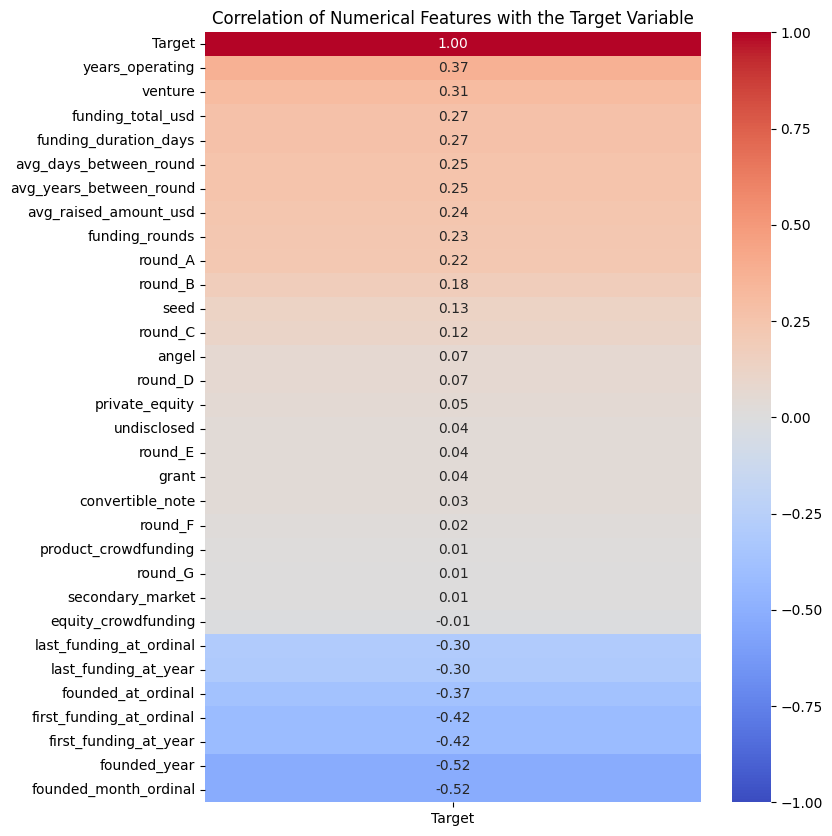

In [ ]:
# corr matrix
numerical_cols = df_features_merged.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numerical_cols.corr()

# Focusing on the correlation of all numerical columns with the 'Target' variable
target_corr = corr_matrix[['Target']].sort_values(by='Target', ascending=False)

# Visualization of the correlation matrix
plt.figure(figsize=(8, 10))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation of Numerical Features with the Target Variable')
plt.show()

### Key Insights from Correlation Analysis

**Years Operating (0.37):**
- A strong positive correlation with years operating indicates that longer operational periods are highly associated with success, suggesting that experience and established presence in the market are critical predictors of positive outcomes.

**Venture (0.31):**
- The moderate positive correlation for venture points towards the importance of solid financial backing and expert guidance in driving business success.

**Funding Duration Days (0.27):**
- This moderate correlation implies that the length of funding rounds plays a significant role in business success, with longer funding periods potentially allowing for more strategic financial planning and resource allocation.

**Total Funding Amount (0.27):**
- Similarly showing a moderate positive correlation, the total funding received by a company is indicative of its ability to secure substantial financial resources, which is essential for scaling operations and achieving business goals.

**Average Years Between Rounds (0.25):**
- This indicates that the time companies take between funding rounds moderately correlates with success. Companies that strategically time their funding rounds to optimize growth and expansion efforts tend to perform better.

We consider variables with $p\text{-value} < 0.05$ as significant. Transformed this would be a value of approximately 1.3 (Indicated by red line)

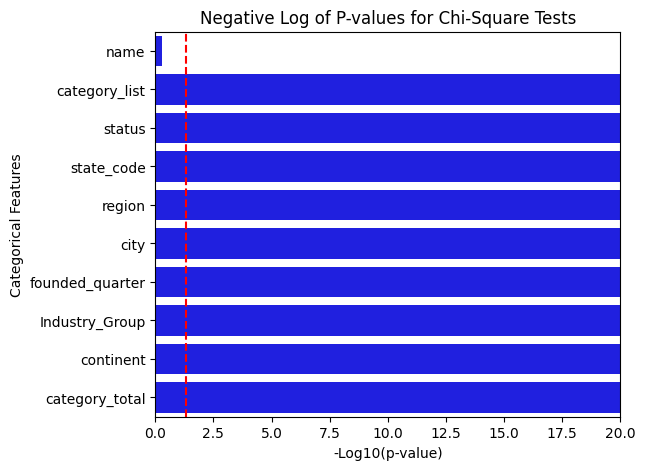

In [ ]:
categorical_cols = df_features_merged.select_dtypes(include=['object', 'category']).columns
target_variable = 'Target' 

chi_square_results = {}

for col in categorical_cols:
    contingency_table = pd.crosstab(df_features_merged[col], df_features_merged[target_variable])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_square_results[col] = p

# List of categories and their -log10(p-value)
categories = list(chi_square_results.keys())
negative_log_p_values = [-np.log10(p) if p > 0 else -np.log10(np.finfo(float).tiny) for p in chi_square_results.values()]

# Plotting the results
plt.figure(figsize=(6, 5))
sns.barplot(x=negative_log_p_values, y=categories, color='blue')
plt.axvline(x=1.3, color='red', linestyle='--')  # Threshold line (-log10(0.05) ~ 1.3)
plt.xlim(0, 20)
plt.title('Negative Log of P-values for Chi-Square Tests')
plt.xlabel('-Log10(p-value)')
plt.ylabel('Categorical Features')
plt.show()


### Mathematical Explanation of Using Negative Logarithm for P-values

The transformation using the negative logarithm for p-values is defined as:

$$
-\log_{10}(p)
$$

**Key Points:**

1. **Amplifies Small Values**: Transforms small p-values into larger, more distinguishable numbers. For example, $p = 10^{-5}$ becomes 5.
2. **Highlights Significance**: A common threshold like $p = 0.05$ transforms to approximately 1.3, making significance levels easier to visualize.
3. **Inverts Scale**: Smaller p-values (more significant) result in larger transformed values, aligning higher values with higher significance.

### Interpreting the Results

- **Higher Values**: Indicate very small original p-values and strong statistical significance.
- **Lower Values**: Suggest larger original p-values and weaker significance.

This transformation allows for better differentiation and prioritization of features based on their statistical importance related to the target variable.


Next we plot pairplots for the 5 highest correlated features with the target variable.

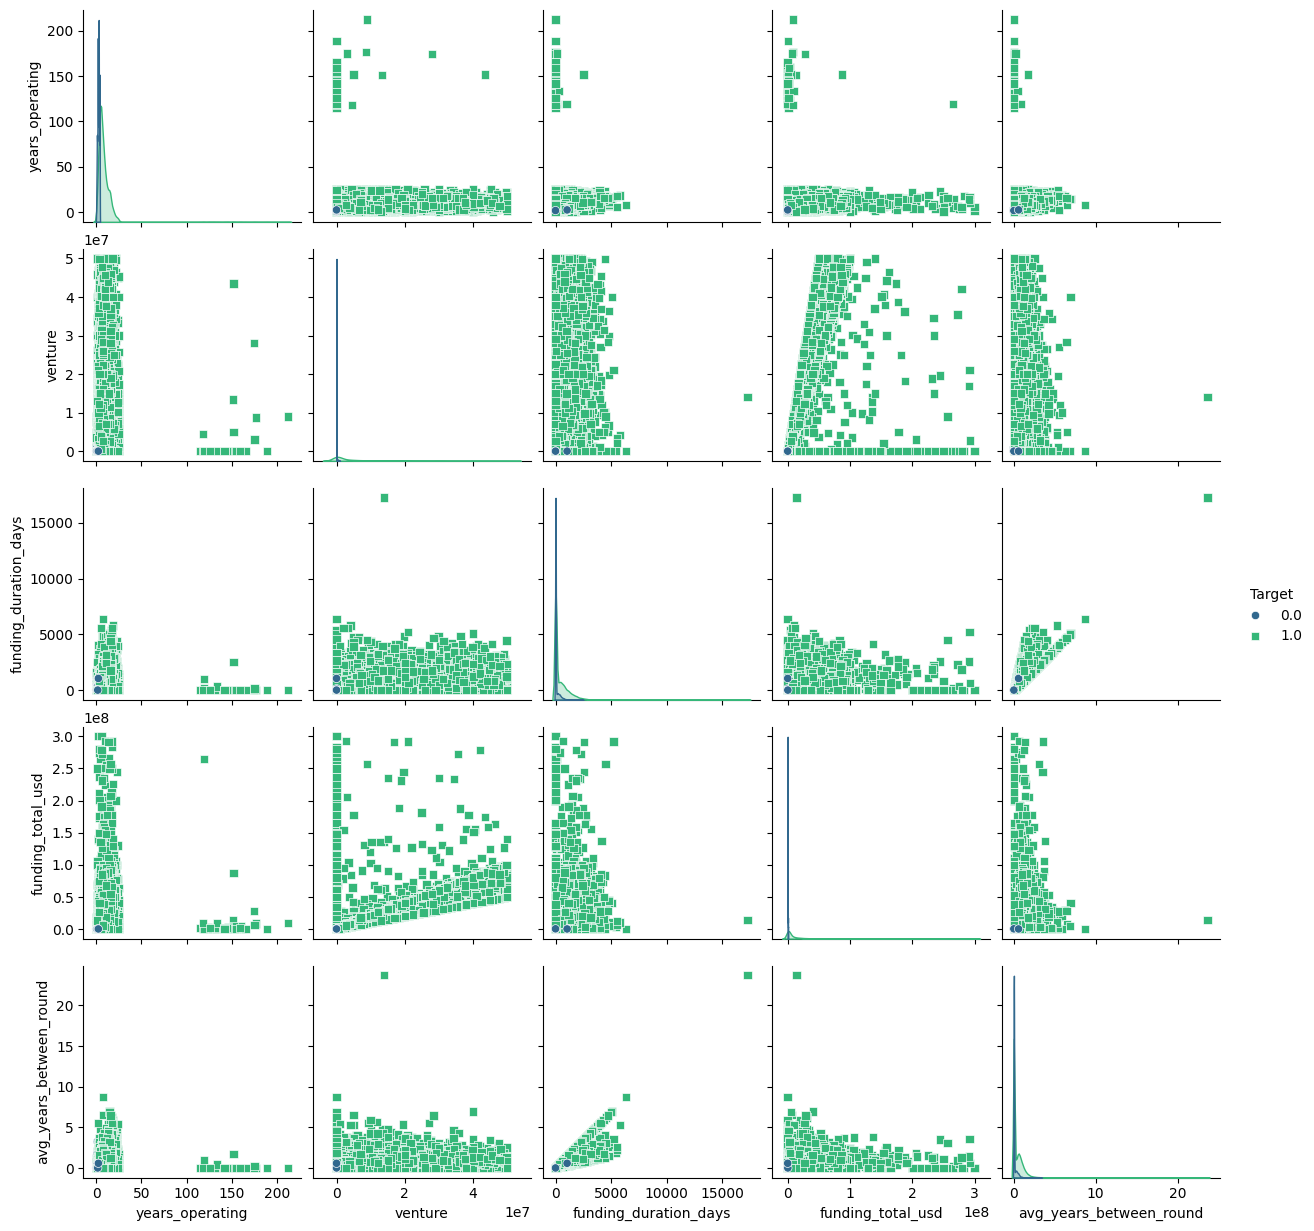

In [ ]:
# Pairplot for 5 highest correlated features

columns_of_interest = [
    'years_operating', 
    'venture',
    'funding_duration_days',
    'funding_total_usd', 
    'avg_years_between_round',   
    'Target'  
]

sns.pairplot(df_features_merged[columns_of_interest], hue='Target', 
             palette='viridis', markers=["o", "s"])

plt.show()

### **Analysis of Pairplots:**

1. **Years Operating vs. Target:**
    - The distribution of years a company has been operating relative to its success shows a clear trend: companies that have been in operation longer are more likely to be successful. This reflects the impact of market experience and stability on success rates.
2. **Venture vs. Target:**
    - The correlation between venture funding and success indicates that companies with higher venture funding tend to show better success rates. This suggests that substantial venture capital support not only provides financial resources but also possibly strategic advantages.
3. **Funding Duration Days vs. Target:**
    - Successful companies tend to have longer funding duration days, implying that prolonged funding periods may allow for more thorough development and execution of business strategies, which are critical in achieving long-term objectives.
4. **Total Funding Amount vs. Target:**
    - There is a noticeable positive correlation between the total amount of funding received and the success of the company. This pattern underscores the importance of substantial financial backing in scaling operations and achieving market success.
5. **Average Years Between Rounds vs. Target:**
    - Companies with shorter average years between funding rounds tend to be more successful, indicating that frequent, timely injections of capital are beneficial for maintaining momentum and competitive edge in the market.

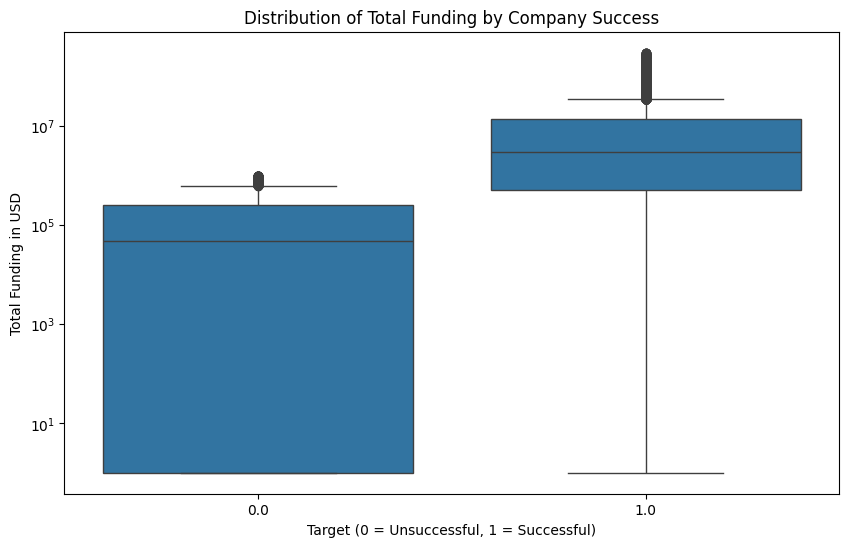

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='funding_total_usd', data=df_features_merged)
plt.title('Distribution of Total Funding by Company Success')
plt.xlabel('Target (0 = Unsuccessful, 1 = Successful)')
plt.ylabel('Total Funding in USD')
plt.yscale('log')  
plt.show()


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


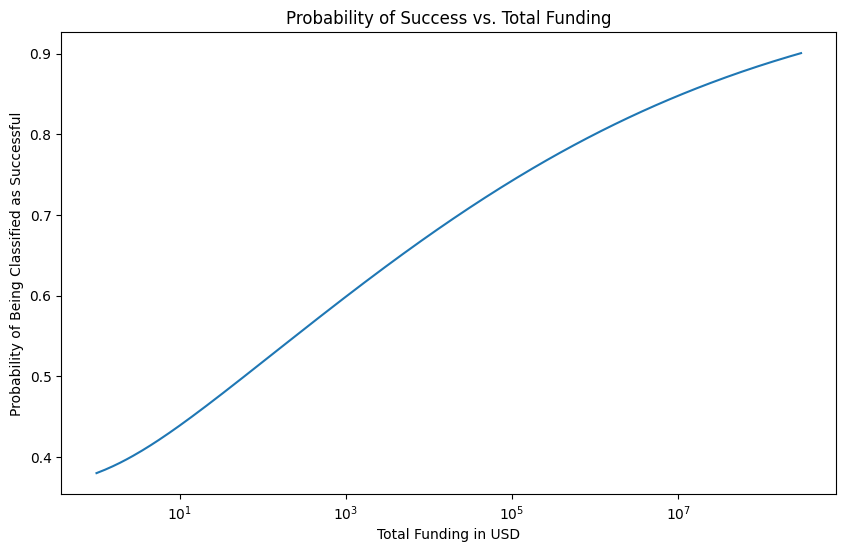

In [ ]:
model = LogisticRegression()
df_features_merged['funding_total_usd_log'] = np.log1p(df_features_merged['funding_total_usd'])  # Log transform for better modeling
model.fit(df_features_merged[['funding_total_usd_log']], df_features_merged['Target'])

# Create a range of values for funding to predict probabilities
funding_range = np.linspace(df_features_merged['funding_total_usd_log'].min(), df_features_merged['funding_total_usd_log'].max(), 300)
probabilities = model.predict_proba(funding_range.reshape(-1, 1))[:, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.expm1(funding_range), probabilities)  
plt.title('Probability of Success vs. Total Funding')
plt.xlabel('Total Funding in USD')
plt.ylabel('Probability of Being Classified as Successful')
plt.xscale('log')  
plt.show()

Both plots show a clear upward trend, indicating that as the total funding increases, so does the likelihood of a company being deemed successful. This suggests that financial backing plays a crucial role in the success of a company, potentially providing the necessary resources for growth, expansion, and overcoming operational challenges. The logarithmic scale on the x-axis underscores that even incremental increases in funding at higher levels can still significantly impact success probabilities. This trend highlights the importance of investment in fostering company success, especially for startups and growth-stage companies.

In [ ]:
successful_companies = df_features_merged[df_features_merged['Target'] == 1]
unsuccessful_companies = df_features_merged[df_features_merged['Target'] == 0]

Top 10 Regions by Highest Success Rate:
              Successful  Total  Success Rate (%)
region                                           
Levis                1.0      1             100.0
Leeds                4.0      4             100.0
Lysaker              2.0      2             100.0
Lulea                1.0      1             100.0
Lucca                1.0      1             100.0
Loughborough         2.0      2             100.0
Livingston           4.0      4             100.0
Linlithgow           2.0      2             100.0
Linkoping           10.0     10             100.0
Lincolnshire         1.0      1             100.0

Top 10 Regions by Lowest Success Rate:
             Successful  Total  Success Rate (%)
region                                          
SAU - Other         0.0      2               0.0
Lake Tahoe          0.0      1               0.0
LTU - Other         0.0      1               0.0
Stanmore            0.0      1               0.0
Vijayawada          0.0   

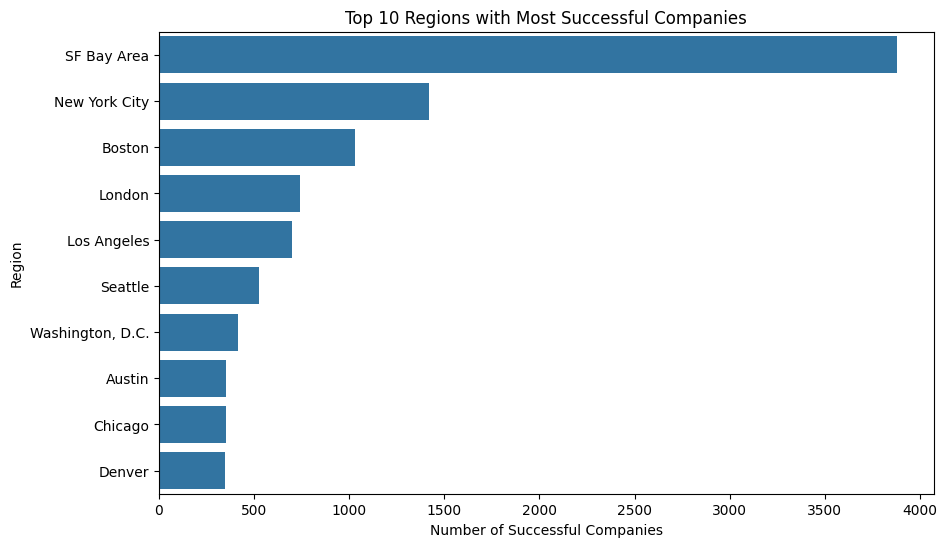

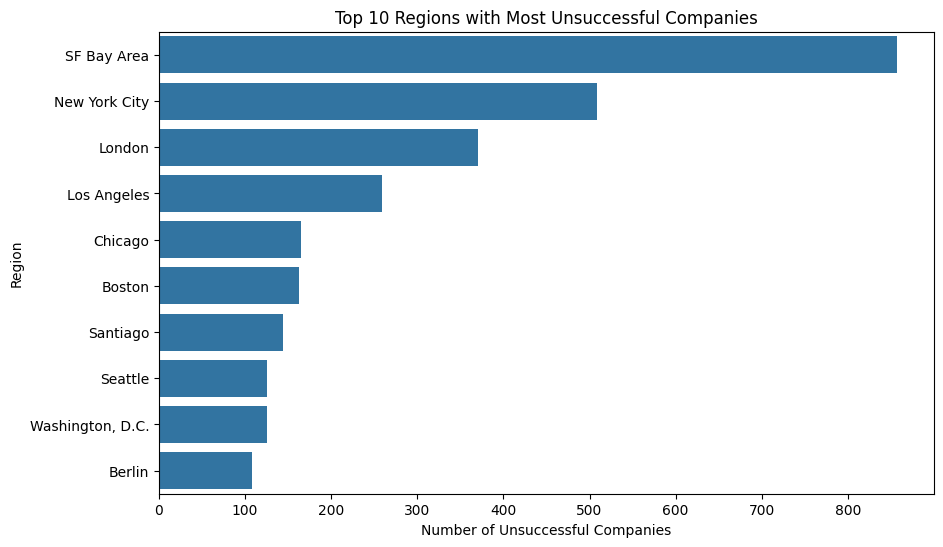

In [ ]:
success_by_region = successful_companies['region'].value_counts()
unsuccess_by_region = unsuccessful_companies['region'].value_counts()
total_companies_per_region = df_features_merged['region'].value_counts()

# Create a DataFrame to store total, successful, and unsuccessful counts
region_summary_df = pd.DataFrame({
    'Total': total_companies_per_region,
    'Successful': success_by_region,
    'Unsuccessful': unsuccess_by_region
})

# Fill missing values with 0 for regions without any successful or unsuccessful companies
region_summary_df.fillna(0, inplace=True)

# Calculate the percentage of successful companies per region
region_summary_df['Success Rate (%)'] = (region_summary_df['Successful'] / region_summary_df['Total'] * 100).round(2)

# Sort regions by highest and lowest success rates
top_success_rates = region_summary_df.sort_values(by='Success Rate (%)', ascending=False).head(10)
bottom_success_rates = region_summary_df.sort_values(by='Success Rate (%)').head(10)

# Print top and bottom regions by success rate
print("Top 10 Regions by Highest Success Rate:")
print(top_success_rates[['Successful', 'Total', 'Success Rate (%)']])
print("\nTop 10 Regions by Lowest Success Rate:")
print(bottom_success_rates[['Successful', 'Total', 'Success Rate (%)']])

plt.figure(figsize=(10, 6))
sns.barplot(x=success_by_region.head(10).values, y=success_by_region.head(10).index)
plt.title('Top 10 Regions with Most Successful Companies')
plt.xlabel('Number of Successful Companies')
plt.ylabel('Region')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=unsuccess_by_region.head(10).values, y=unsuccess_by_region.head(10).index)
plt.title('Top 10 Regions with Most Unsuccessful Companies')
plt.xlabel('Number of Unsuccessful Companies')
plt.ylabel('Region')
plt.show()

Analyzing the success rates by region provides crucial insights into geographical disparities in business outcomes. Regions with higher concentrations of successful companies, such as the San Francisco Bay Area, New York City, and Boston, often benefit from established ecosystems that provide better access to funding, talent, and networking opportunities. These ecosystems can significantly enhance a startup's chances of success. This geographical concentration aligns with the data used in our model, where America as a continent features prominently due to its high number of startups.

## 4. Modeling


In [ ]:
X = df_features_merged[["avg_raised_amount_usd","avg_years_between_round","Industry_Group", "funding_rounds", "continent"]]
y = df_features_merged["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y) # increased test size due to unbalanced dataset and stratify to balance test & train

In [ ]:
numerical_cols = ["avg_raised_amount_usd", "avg_years_between_round", "funding_rounds"]
high_cardinality_cols = ["Industry_Group"] 
categorical_cols = ["continent"] 

In [ ]:
print(f'Size of training set: {X_train.shape[0]}, size of test set {X_test.shape[0]}')

Size of training set: 20841, size of test set 8932


### 4.1 Logistic Regression

Explanation: Logistic Regression estimates probabilities using a logistic function, which is particularly designed for binary classification problems. It outputs values between 0 and 1, interpreted as the probability of belonging to a particular class.
Why it makes sense: Since the relationship between our input variables and the target variable is approximately linear (our assumption), Logistic Regression could perform well. It's efficient and provides useful coefficients that indicate the importance of each feature (avg_years_between_round, funding_rounds, etc.) in predicting the target. This can offer valuable insights into which factors most influence start-up success or failure.

### Model Setup and Decision Rationale

#### 1. Choice of Encoders and Scalers

- **RobustScaler**: Used for numerical columns to reduce the impact of outliers, utilizing median and quartile range instead of mean and variance.
- **TargetEncoder**: Applied to high-cardinality columns to manage dimensionality efficiently by converting categories in one column.
- **OneHotEncoder**: Employed for other categorical columns to convert categories into a binary matrix, essential for logistic regression.

#### 2. Explanation of Parameter Choices for Logistic Regression

##### 1. `C` (Inverse of regularization strength)
- **Purpose**: Controls the regularization to prevent overfitting.
- **Range**: `loguniform(0.001, 10)` to explore a wide range of strengths, from very strong to very weak regularization.

##### 2. `penalty` (Norm used in penalization)
- **Purpose**: Determines the type of regularization (`l1` for Lasso, `l2` for Ridge).
- **Range**: `['l1', 'l2']` to test both, allowing feature selection with `l1` and more even penalty distribution with `l2`.

##### 3. `max_iter` (Maximum iterations for solver convergence)
- **Purpose**: Ensures the solver can converge to an optimal solution.
- **Range**: `[100, 200, 300, 400, 500]` offers sufficient flexibility for convergence across various scenarios.

#### 3. Utilizing RandomizedSearchCV

We employed `RandomizedSearchCV` to conduct an extensive exploration of parameter combinations (`C` and `penalty`) for our logistic regression model. This approach ensures thorough testing of a wide range of parameter values by randomly sampling from the specified parameter distributions. Unlike `GridSearchCV`, which evaluates every combination within a predefined grid, `RandomizedSearchCV` randomly selects a subset of combinations to evaluate, making it computationally more efficient for large parameter spaces.

By leveraging RandomizedSearchCV's built-in cross-validation functionality, we effectively evaluate the model's performance on various subsets of the data, reducing the risk of overfitting. This eliminates the need for a separate validation set, as `RandomizedSearchCV` inherently performs this validation during the search process. 

#### 4. Data Imputation

Data imputation was unnecessary as our dataset was pre-cleaned, ensuring no NaN values were present. This allowed us to proceed directly with modeling on a complete dataset.

These decisions optimize our model’s effectiveness by tailoring preprocessing to feature types and ensuring comprehensive hyperparameter tuning while effectively managing dataset integrity.

In [ ]:
all_categorical_cols = high_cardinality_cols + categorical_cols

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat_high_card', TargetEncoder(), high_cardinality_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

pipe_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', 'passthrough'), 
    ('logreg', LogisticRegression(solver="liblinear", random_state=42))
])

param_distributions = {
    'logreg__C': loguniform(0.001, 10), 
    'logreg__penalty': ['l1', 'l2'],
    'logreg__max_iter': [100, 200, 300, 400, 500],  
    'sampler': [
        RandomOverSampler(random_state=42),
        SMOTENC(categorical_features=[i for i, col in enumerate(numerical_cols + high_cardinality_cols + categorical_cols) if col in all_categorical_cols], random_state=42),
        None  # Represents no sampling
    ]
}

random_search_lr = RandomizedSearchCV(pipe_lr, param_distributions, n_iter=100, cv=5, scoring='f1', n_jobs=-1, random_state=42, error_score='raise')
random_search_lr.fit(X_train, y_train)

print("Best cross-validation score:", random_search_lr.best_score_)
print("Best parameters:", random_search_lr.best_params_)
lr_df = pd.DataFrame(random_search_lr.cv_results_)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: Conv

## Categorical Feature Encoding

For our machine learning project, we opted to utilize **Target Encoding** to handle a high cardinality categorical feature. This decision was driven by several factors outlined below:

### Why Target Encoding?
- **No Increase in Feature Space**: Unlike methods such as one-hot encoding, target encoding does not expand the feature space, which is crucial for managing high-dimensional data efficiently.
- **Simplicity**: It's a parameter-free approach that doesn't require additional tuning, making it straightforward to implement.

### Acknowledged Limitations
However, we are aware of the limitations and risks associated with target encoding:
- **Risk of Target Leakage**: Target encoding can inadvertently introduce future information into the training process, potentially leading to overfitting. We took careful steps to mitigate this by properly handling our data split and applying encoding after separating the train and test sets.
- **Handling of Rare Categories**: For categories with few samples, target encoding may assign values too close to the overall target mean, which could bias our model. We addressed this by ensuring a robust validation strategy to detect any overfitting.
- **Introduction of Ordinality**: There's a risk that target encoding may imply an order where none exists, as it assigns numeric values based on the target mean. This can mislead the model into treating nominal categories as ordinal.

### Alternatives Considered
Other encoding strategies were considered, including:
- **Count Encoding**: Simple and intuitive by using the frequency of categories. However, it can oversimplify and lose valuable information.
- **Feature Hashing**: Useful for datasets with an extremely high number of categories and provides a fixed-size representation but requires careful tuning and is susceptible to collisions.
- **Embeddings**: Effective at capturing relationships between categories and suitable for new category values. Requires a two-step model training process, which increases complexity.

Despite the potential alternatives, **Target Encoding** was chosen for its balance of simplicity and effectiveness, particularly in handling features with high cardinality without expanding the feature space. 


### Feature importance

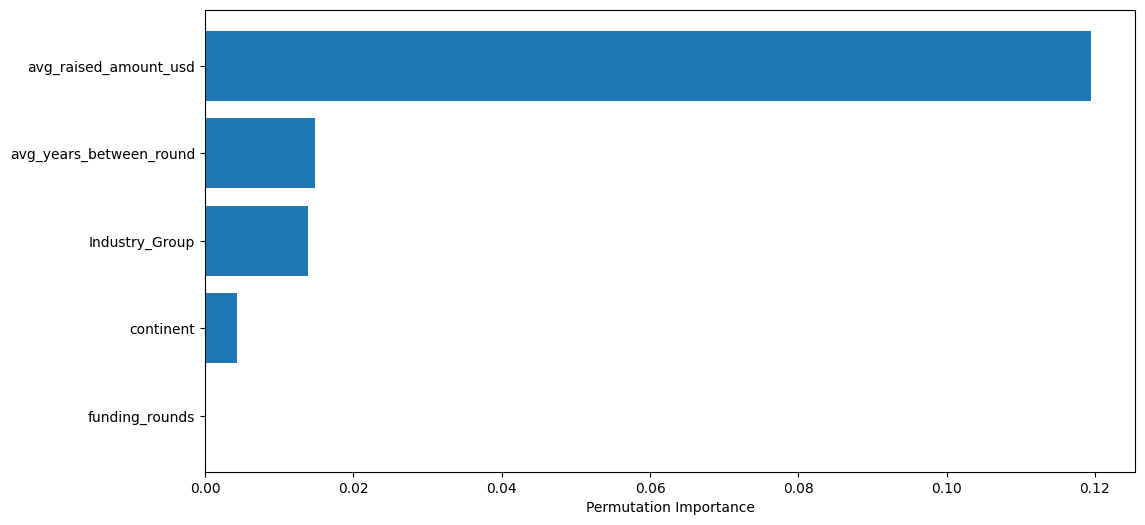

In [ ]:
pipe_lr.fit(X_train, y_train)

perm_importance_lr = permutation_importance(pipe_lr, X_train, y_train, n_repeats=30, random_state=0, n_jobs=-1)


sorted_idx = perm_importance_lr.importances_mean.argsort()
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance_lr.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

### 4.2 Decision Tree

Explanation: A Decision Tree is a flowchart-like structure where each internal node represents a feature decision point, each branch represents the outcome of that decision, and each leaf node represents a class label. It's a non-linear model that can easily handle complex decision-making processes.
Why it makes sense: Decision Trees are intuitive and easy to interpret, making them ideal for gaining insights into the decision-making process. They can naturally handle a mix of data types and are capable of capturing complex relationships between features and the target. For predicting start-up success, where decisions could hinge on thresholds of funding rounds or specific industry groups, Decision Trees offer a clear methodology for understanding these dynamics.

### Decision Tree Model Setup and Decision Rationale

#### 1. Feature Handling

- **Passthrough for Numerical Features**: Unlike in logistic regression where scaling might be crucial due to optimization algorithms that assume data on similar scales, for decision trees, scaling is unnecessary. The model's splits are based on the order of data points, not their magnitude, allowing us to use the raw numerical values directly. 

#### 2. Explanation of Parameter Choices for Decision Tree Classifier

##### 1. `max_depth` 
- **Purpose**: Controls the depth of the tree to prevent overfitting.
- **Range**: `np.arange(1, 8)` offers a span from shallow to moderately deep trees, balancing model complexity and generalization.

##### 2. `min_samples_leaf`
- **Purpose**: Sets the minimum number of samples required to be at a leaf node, influencing the granularity of the tree.
- **Range**: `np.arange(1, 8)` allows for a range of constraints from very flexible (1) to more general (7).

##### 3. `criterion`
- **Purpose**: Defines the function used to measure the quality of a split (`gini` for Gini impurity and `entropy` for information gain).
- **Range**: `["gini", "entropy"]` to test both measures and see which performs better in optimizing splits and overall model accuracy.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_high_card', TargetEncoder(), high_cardinality_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Passthrough numerical features without scaling, since it´s not needed here
)

# Create a pipeline 
pipe_dt = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', 'passthrough'),
    ('dt', DecisionTreeClassifier(random_state=42))  
])

param_distributions = {
    'dt__max_depth': np.arange(1, 8),  
    'dt__min_samples_leaf': np.arange(1, 8), 
    'dt__criterion': ["gini", "entropy"],  
    'sampler': [
        RandomOverSampler(random_state=42),
        SMOTENC(categorical_features=[i for i, col in enumerate(numerical_cols + high_cardinality_cols + categorical_cols) if col in all_categorical_cols], random_state=42),
        None  
    ]
}

random_search_dt = RandomizedSearchCV(
    pipe_dt,
    param_distributions=param_distributions,
    n_iter=100, 
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

random_search_dt.fit(X_train, y_train)

print("Best cross-validation score:", random_search_dt.best_score_)
dt_df = pd.DataFrame(random_search_dt.cv_results_)

Best cross-validation score: 0.8601694753175856


### 4.3 KNN

Explanation: KNN works by finding the 'k' training samples closest in distance to a new point and predicts the label by majority vote. It's a non-parametric, lazy learning algorithm.
Why it makes sense: KNN is effective for classification when the decision boundary is not linear. It can handle a mix of categorical and numerical data, especially useful in your our with features like category Industry Group and avg funding total. It's a good baseline model to start with due to its simplicity.

### K-Nearest Neighbors (KNN) Model Setup and Decision Rationale

#### 1. Feature Scaling Importance

- **RobustScaler**: Unlike decision trees and similar to logistic regression, feature scaling is critical for KNN due to its reliance on distance calculations between data points. However, `RobustScaler` is specifically chosen over other scalers because it minimizes the influence of outliers, which is vital in maintaining the integrity of the distance measurements in KNN.

#### 2. Explanation of Parameter Choices for K-Nearest Neighbors Classifier

##### 1. `n_neighbors`
- **Purpose**: Specifies the number of neighbors to use for voting in the classification. Affects the sensitivity to noise and model complexity.
- **Range**: `randint(1, 21)` provides a wide range of neighbors to explore, from very local (1) to more generalized (20) decision boundaries.

##### 2. `weights`
- **Purpose**: Determines if all neighbors should contribute equally (`uniform`) or if closer neighbors should have a greater influence (`distance`).
- **Range**: `['uniform', 'distance']` allows testing both methods to see which better handles the trade-off between bias and variance in your specific dataset.

##### 3. `p`
- **Purpose**: Defines the power parameter for the Minkowski metric, where 1 is Manhattan distance and 2 is Euclidean distance.
- **Range**: `[1, 2]` enables exploration of different distance calculations to see which is more effective for the dataset's geometry and distribution.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat_high_card', TargetEncoder(), high_cardinality_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Create a pipeline 
pipe_knn = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', 'passthrough'),
    ('knn', KNeighborsClassifier())
])

param_distributions = {
    'knn__n_neighbors': randint(1, 21),  
    'knn__weights': ['uniform', 'distance'],  
    'knn__p': [1, 2],  
    'sampler': [
        RandomOverSampler(random_state=42),
        SMOTENC(categorical_features=[i for i, col in enumerate(numerical_cols + high_cardinality_cols + categorical_cols) if col in all_categorical_cols], random_state=42),
        None  
    ]
}

random_search_knn = RandomizedSearchCV(
    pipe_knn,
    param_distributions=param_distributions,
    n_iter=100,  
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

random_search_knn.fit(X_train, y_train)

print("Best cross-validation score:", random_search_knn.best_score_)
knn_df = pd.DataFrame(random_search_knn.cv_results_)

Best cross-validation score: 0.8589270238862656


### Feature importance

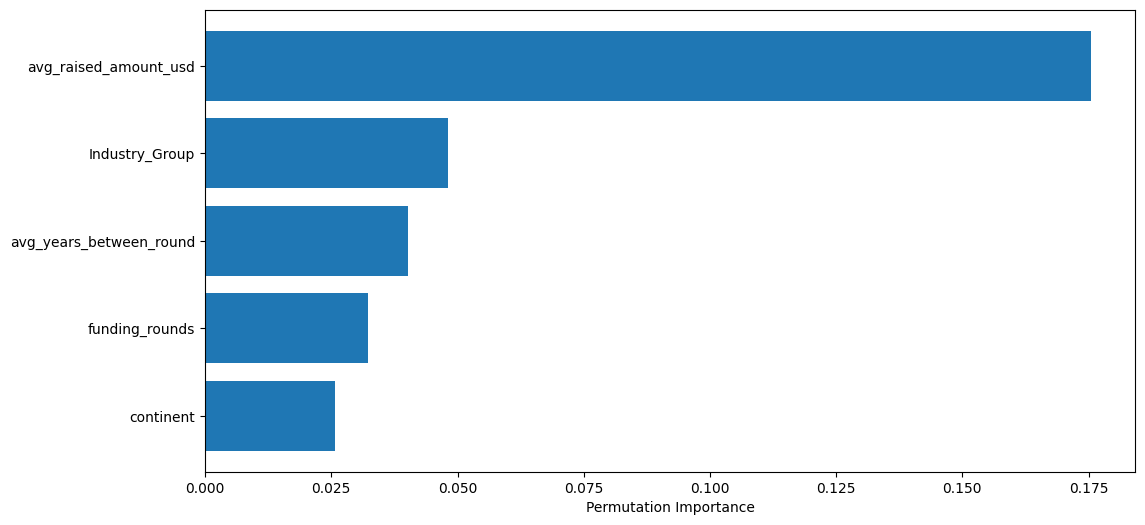

In [ ]:
pipe_knn.fit(X_train, y_train)

perm_importance_knn = permutation_importance(pipe_knn, X_train, y_train, n_repeats=2, random_state=0, n_jobs=-1)

sorted_idx = perm_importance_knn.importances_mean.argsort()
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance_knn.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

avg_raised_amount_usd seems to be the most efficient parameter to determine success or no_success

## 5. Ensemble Learning

### 5.1 Random Forest

Explanation: Random Forest is an ensemble method that uses multiple decision trees to make predictions, reducing the risk of overfitting associated with single decision trees. It introduces randomness in the selection of features and samples, creating diverse trees.
Why it makes sense: Given the diversity of features (avg_raised_amount_usd, category_Industry_Group, etc.) and the complexity of interactions in our dataset, Random Forest can capture nonlinear relationships without heavily overfitting. It's robust to outliers and can handle categorical and numerical data well, making it a powerful tool for binary classification problems like ours.

### Random Forest Model Setup and Decision Rationale

#### 1. Explanation of Parameter Choices for Random Forest Classifier

##### 1. `max_depth`
- **Purpose**: Limits the depth of each tree in the forest to control overfitting by reducing the complexity of the learned models.
- **Range**: `randint(1, 8)` offers a spectrum from shallow (less complex, less likely to overfit) to moderately deep trees (can capture more complex patterns).

##### 2. `min_samples_leaf`
- **Purpose**: Sets the minimum number of samples required to form a leaf node, which can help in smoothing the model, especially in regression.
- **Range**: `randint(1, 8)` allows the model to explore a range of values from allowing very specific to more generalized leaf formulations.

##### 3. `criterion`
- **Purpose**: The function to measure the quality of a split. `gini` for the Gini impurity and `entropy` for the information gain - both are measures of node purity.
- **Range**: `["gini", "entropy"]` provides two different methods for handling splits, influencing how trees in the forest decide on the best splits.

##### 4. `n_estimators`
- **Purpose**: Number of trees in the forest. More trees increase robustness but also computational demand.
- **Range**: `randint(1, 100)` enables significant variability to study the stability versus complexity trade-off as more trees are added.

##### 5. `max_features`
- **Purpose**: The number of features to consider when looking for the best split, influencing the diversity of the trees in the forest.
- **Range**: `['sqrt', 'log2']` typically sqrt(number of features) or log2(number of features) are used to ensure each tree in the forest is trained on different feature subsets, thereby increasing model diversity and preventing overfitting.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_high_card', TargetEncoder(), high_cardinality_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  
)

pipe_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', 'passthrough'),
    ('rf', RandomForestClassifier())
])

distributions = {
    'rf__max_depth': randint(1, 8),
    'rf__min_samples_leaf': randint(1, 8),
    'rf__criterion': ["gini", "entropy"],
    'rf__n_estimators': randint(1, 100),  
    'rf__max_features': ['sqrt', 'log2'], 
    'sampler': [
        RandomOverSampler(random_state=42),
        SMOTENC(categorical_features=[i for i, col in enumerate(numerical_cols + high_cardinality_cols + categorical_cols) if col in all_categorical_cols], random_state=42),
        None  
    ]
}

random_search_rf = RandomizedSearchCV(pipe_rf, distributions, n_iter=100, random_state=42, cv=5, scoring='f1', n_jobs=-1)
random_search_rf.fit(X_train, y_train)

print("Best score:", random_search_rf.best_score_)
print("Best parameters:", random_search_rf.best_params_)
rf_df = pd.DataFrame(random_search_rf.cv_results_)

Best score: 0.8626297772792378
Best parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__n_estimators': 58, 'sampler': None}


### 5.2 XGBoost

Explanation: XGBoost, short for eXtreme Gradient Boosting, is an advanced implementation of gradient boosting algorithms. It builds multiple decision trees sequentially, each tree correcting the errors of the previous one. XGBoost is known for its computational efficiency, scalability, and outstanding performance in various machine learning competitions.
Why it makes sense: XGBoost is well-suited for our binary classification problem due to its ability to handle large datasets with high dimensionality. It automatically handles missing values, supports regularization techniques to prevent overfitting, and provides built-in cross-validation functionality. Additionally, its tree-pruning capabilities help to avoid overfitting and improve model generalization.

### XGBoost Model Setup and Decision Rationale

#### 1. Explanation of Parameter Choices for Random Forest Classifier

##### 1. `max_depth`
- **Purpose**: Controls the maximum depth of each tree, which impacts the model's ability to learn detailed data specifics, aiding in more complex pattern recognition but potentially leading to overfitting.
- **Range**: `randint(1, 11)` provides a range from shallow to deep trees, allowing flexibility in balancing bias and variance.

##### 2. `min_child_weight`
- **Purpose**: Minimum sum of instance weight (hessian) needed in a child node, used to control overfitting by making the algorithm more conservative.
- **Range**: `randint(1, 8)` varies from requiring minimal to more significant sample weight, affecting the decision node creation in each tree.

##### 3. `subsample`
- **Purpose**: Ratio of the training instances. Subsampling will randomly sample part of the training data set at each boosting step, which can make the training faster and prevent overfitting.
- **Range**: `uniform(0.6, 0.4)` adjusts from 60% to 100% of the data, providing variability in how much data each tree is trained on.

##### 4. `colsample_bytree`
- **Purpose**: The proportion of features used during each boosting round, used to prevent overfitting similarly to max_features in random forests.
- **Range**: `uniform(0.6, 0.4)` ranges from 60% to 100% feature usage in individual trees, controlling feature selection for diversity in model training.

##### 5. `learning_rate`
- **Purpose**: Step size shrinkage used to prevent overfitting. It scales the contribution of each tree by this factor.
- **Range**: `uniform(0.03, 0.27)` provides a learning rate from very slow learning (0.03) to relatively fast (0.3), which can significantly impact the convergence speed and final model performance.

##### 6. `n_estimators`
- **Purpose**: Number of gradient boosted trees. Similar to learning rate, it plays a critical role in model complexity and potential for overfitting.
- **Range**: `randint(100, 1001)` allows for a wide range of trees from 100 to 1000, enabling the exploration of both underfitting and overfitting scenarios depending on the problem complexity and dataset size.


In [ ]:
preprocessor_xg = ColumnTransformer(
    transformers=[
        ('cat_high_card', TargetEncoder(), high_cardinality_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  
)

xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_xg),
    ('sampler', 'passthrough'),
    ('xgb', XGBClassifier(objective='binary:logistic', verbosity=1))
])

param_distributions = {
    'xgb__max_depth': randint(1, 11),
    'xgb__min_child_weight': randint(1, 8),
    'xgb__subsample': uniform(0.6, 0.4),  # From 0.6 to 1.0
    'xgb__colsample_bytree': uniform(0.6, 0.4),  # From 0.6 to 1.0
    'xgb__learning_rate': uniform(0.003, 0.27),  # From 0.03 to 0.3
    'xgb__n_estimators': randint(100, 1001),
    'sampler': [
        RandomOverSampler(random_state=42),
        SMOTENC(categorical_features=[i for i, col in enumerate(numerical_cols + high_cardinality_cols + categorical_cols) if col in all_categorical_cols], random_state=42),
        None  
    ]
}

random_search_xgb = RandomizedSearchCV(
    xgb_pipeline, param_distributions, cv=5,
    n_iter=100, random_state=42, scoring='f1', n_jobs=-1, verbose=3
)

random_search_xgb.fit(X_train, y_train)

print("Best score: ", random_search_xgb.best_score_)
print("Best parameters: ", random_search_xgb.best_params_)
xgb_df = pd.DataFrame(random_search_xgb.cv_results_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END sampler=None, xgb__colsample_bytree=0.9186171947440931, xgb__learning_rate=0.05252739326386423, xgb__max_depth=8, xgb__min_child_weight=5, xgb__n_estimators=120, xgb__subsample=0.6624074561769746;, score=0.867 total time=   0.2s
[CV 3/5] END sampler=None, xgb__colsample_bytree=0.9186171947440931, xgb__learning_rate=0.05252739326386423, xgb__max_depth=8, xgb__min_child_weight=5, xgb__n_estimators=120, xgb__subsample=0.6624074561769746;, score=0.865 total time=   0.2s
[CV 4/5] END sampler=None, xgb__colsample_bytree=0.9186171947440931, xgb__learning_rate=0.05252739326386423, xgb__max_depth=8, xgb__min_child_weight=5, xgb__n_estimators=120, xgb__subsample=0.6624074561769746;, score=0.863 total time=   0.2s
[CV 2/5] END sampler=None, xgb__colsample_bytree=0.9186171947440931, xgb__learning_rate=0.05252739326386423, xgb__max_depth=8, xgb__min_child_weight=5, xgb__n_estimators=120, xgb__subsample=0.6624074561769746;, 

### 5.3 CatBoost

Explanation: CatBoost is a gradient boosting library developed by Yandex that specializes in handling categorical features effectively. It implements an algorithm similar to XGBoost and LightGBM but with built-in support for categorical variables. CatBoost uses a technique called ordered boosting, which reduces the need for preprocessing categorical features such as one-hot encoding or label encoding.
Why it makes sense: In our dataset, which contains categorical features such as industry groups or regions, CatBoost's native support for categorical variables is advantageous. By handling categorical data efficiently, CatBoost can improve model performance and reduce the risk of information loss during preprocessing. Its ability to handle categorical features without extensive feature engineering makes it a suitable choice for our binary classification problem.

### CatBoost Model Setup and Decision Rationale

#### 1. Explanation of Parameter Choices for CatBoost Classifier

##### 1. `iterations`
- **Purpose**: Determines the number of trees to be built, directly influencing the model's ability to learn from data.
- **Range**: `randint(100, 1001)` allows for a broad range of complexity, from a relatively simple model to a highly detailed one, ensuring robustness and depth in learning.

##### 2. `learning_rate`
- **Purpose**: Controls the training step size to prevent overfitting. A smaller learning rate requires more trees but can lead to better generalization.
- **Range**: `uniform(0.01, 0.29)` spans a slow to moderate pace, enabling detailed tuning of the speed at which the model learns patterns in the data.

##### 3. `depth`
- **Purpose**: Sets the depth of each tree, affecting how specific the learned patterns can be. Deeper trees can model more complex relationships but might overfit.
- **Range**: `randint(3, 11)` provides flexibility from shallow to deep trees, affecting both performance and computational cost.

##### 4. `l2_leaf_reg`
- **Purpose**: Adds L2 regularization to the loss function. This parameter helps reduce model complexity and prevent overfitting by penalizing large weights.
- **Range**: `uniform(0, 10)` offers a scale of regularization intensity, allowing the model to adjust the balance between bias and variance.

##### 5. `subsample`
- **Purpose**: Specifies the subsample ratio of the training instance. Subsampling prevents overfitting and affects the randomness of the model, akin to bagging.
- **Range**: `uniform(0.6, 0.4)` explores different degrees of training data utilization from 60% to 100%, modifying how each tree in the ensemble is built.

##### 6. `colsample_bylevel`
- **Purpose**: Determines the fraction of features used for each split decision in learning the data at every level of each tree.
- **Range**: `uniform(0.4, 0.6)` from 40% to 100% of features, enhancing diversity in the model and helping prevent overfitting by not always using all available features.


In [ ]:
pipe_cb = ImbPipeline([
    ('sampler', 'passthrough'),
    ('cb', CatBoostClassifier(od_type='Iter', bootstrap_type='Bernoulli', od_wait=50, cat_features=high_cardinality_cols + categorical_cols))
])

# Define the parameter grid for GridSearchCV
param_distributions = {
    'cb__iterations': randint(100, 1001),  
    'cb__learning_rate': uniform(0.001, 0.29), 
    'cb__depth': randint(3, 11),  
    'cb__l2_leaf_reg': uniform(0, 10),  
    'cb__subsample': uniform(0.6, 0.4), 
    'cb__colsample_bylevel': uniform(0.4, 0.6), 
    'sampler': [
        RandomOverSampler(random_state=42),
        SMOTENC(categorical_features=[i for i, col in enumerate(numerical_cols + high_cardinality_cols + categorical_cols) if col in all_categorical_cols], random_state=42),
        None  
    ]
}

random_search_cb = RandomizedSearchCV(
    pipe_cb,
    param_distributions=param_distributions,
    n_iter=10, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=3,
    random_state=42
)

random_search_cb.fit(X_train, y_train)

print("Best F1 score:", random_search_cb.best_score_)
print("Best parameters:", random_search_cb.best_params_)
cb_df = pd.DataFrame(random_search_cb.cv_results_)

342:	learn: 0.3037400	total: 9.33s	remaining: 708ms
317:	learn: 0.3067857	total: 9.02s	remaining: 1.45s
343:	learn: 0.3036398	total: 9.35s	remaining: 680ms
324:	learn: 0.3059191	total: 9.16s	remaining: 1.24s
304:	learn: 0.3063233	total: 8.93s	remaining: 1.87s
318:	learn: 0.3067132	total: 9.05s	remaining: 1.42s
325:	learn: 0.3058042	total: 9.18s	remaining: 1.21s
344:	learn: 0.3035297	total: 9.37s	remaining: 652ms
305:	learn: 0.3062828	total: 8.95s	remaining: 1.84s
319:	learn: 0.3066062	total: 9.11s	remaining: 1.4s
326:	learn: 0.3057347	total: 9.23s	remaining: 1.19s
345:	learn: 0.3034668	total: 9.43s	remaining: 627ms
306:	learn: 0.3061527	total: 9.01s	remaining: 1.82s
327:	learn: 0.3055730	total: 9.25s	remaining: 1.16s
320:	learn: 0.3065453	total: 9.13s	remaining: 1.36s
328:	learn: 0.3055326	total: 9.26s	remaining: 1.13s
346:	learn: 0.3033750	total: 9.46s	remaining: 600ms
307:	learn: 0.3060354	total: 9.03s	remaining: 1.79s
321:	learn: 0.3064564	total: 9.15s	remaining: 1.33s
308:	learn: 0

## 6. Neural Network

Explanation: A neural network is a computational model inspired by the structure and functioning of the human brain. It consists of interconnected nodes organized in layers, including an input layer, one or more hidden layers, and an output layer. Neural networks are capable of learning complex patterns and relationships from data through a process called backpropagation, where the network adjusts its weights to minimize prediction errors.
Why it makes sense: For our binary classification problem, a neural network offers flexibility in capturing intricate nonlinear relationships between features. It can automatically learn hierarchical representations of the input data, potentially uncovering hidden patterns that might be challenging for traditional machine learning algorithms. 

**Model Architecture**:
- `BinaryClassifier` defines a neural network architecture within a sequential model.
- It contains fully connected layers (`nn.Linear`) with a hierarchy of neurons: 128, 64, and 32, culminating in a single output neuron.
- `nn.ReLU` is used as the activation function for hidden layers, introducing non-linearity and defined as: $$ f(x) = \max(0, x) $$
- The output layer utilizes `nn.Sigmoid` to constrain the output between 0 and 1, mathematically represented as: $$ f(x) = \frac{1}{1 + e^{-x}} $$

**Training Loop**:
- `DataLoader` batches and shuffles the data, improving training efficiency.
- `device` is set to utilize GPU for acceleration if available.
- The loss function, `BCELoss` (Binary Cross-Entropy Loss), is suitable for binary outcomes and is given by: $$ L = -[y \log(p) + (1 - y) \log(1 - p)] $$ where \(y\) is the target and \(p\) is the model's predicted probability.
- `optim.Adam` is the optimizer with a learning rate (`lr`) of 0.001, a typical starting value.
- Early Stopping: To prevent overfitting and optimize training duration, early stopping is implemented. Training halts if the validation loss does not improve after a specified number of epochs (`patience`). For this model, `patience` is set to 5 epochs, meaning the training will stop if there is no improvement in the validation loss for 5 consecutive epochs. The `verbose` flag is set to `True` to ensure feedback is provided on the training process during each epoch where early stopping is evaluated. Additionally, the `delta` is set to 0, indicating that any improvement in the validation loss, no matter how small, will reset the patience counter. This strategy saves computational resources and ensures the model does not overfit by continually learning from the training data without corresponding improvements in validation performance.

**Data Splitting**: 
- To align the validation strategy with our other models that use 5-fold cross-validation, the training data is split into a training set and a validation set with a ratio of 0.8/0.2. This split ensures that 20% of the training data serves as the validation set, which effectively replicates the validation proportion typically used in one fold of 5-fold cross-validation. This approach allows for consistent model evaluation and performance comparison across different training setups.



Parameters such as the number of layers, size of layers, and learning rate are selected based on standard practices for a binary classification task and can be adjusted based on model performance.


In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat_high_card', TargetEncoder(), high_cardinality_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

pipeline = Pipeline([
    ('preprocessing', preprocessor)
])

pipeline.fit(X_train_nn, y_train_nn)

X_train_transformed = pipeline.transform(X_train_nn)
X_val_transformed = pipeline.transform(X_val_nn)

y_train_nn = y_train_nn.reset_index(drop=True)
X_train_tensor = torch.tensor(X_train_transformed.astype(np.float32))
y_train_tensor = torch.tensor(y_train_nn.astype(np.float32)).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_transformed.astype(np.float32))
y_val_tensor = torch.tensor(y_val_nn.to_numpy().astype(np.float32)).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) 

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# Set device and initialize model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier(X_train_tensor.shape[1]).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} to {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# Training loop with early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
    
    avg_val_loss = np.mean(val_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}')

    # Call early stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch [1/50], Loss: 0.2711, Val Loss: 0.3539
Validation loss decreased (inf to 0.353923). Saving model...
Epoch [2/50], Loss: 0.4479, Val Loss: 0.3424
Validation loss decreased (0.353923 to 0.342406). Saving model...
Epoch [3/50], Loss: 0.1564, Val Loss: 0.3396
Validation loss decreased (0.342406 to 0.339583). Saving model...
Epoch [4/50], Loss: 0.3908, Val Loss: 0.3394
Validation loss decreased (0.339583 to 0.339387). Saving model...
Epoch [5/50], Loss: 0.2788, Val Loss: 0.3370
Validation loss decreased (0.339387 to 0.336997). Saving model...
Epoch [6/50], Loss: 0.2297, Val Loss: 0.3360
Validation loss decreased (0.336997 to 0.336039). Saving model...
Epoch [7/50], Loss: 0.4046, Val Loss: 0.3429
EarlyStopping counter: 1 out of 5
Epoch [8/50], Loss: 0.4035, Val Loss: 0.3338
Validation loss decreased (0.336039 to 0.333797). Saving model...
Epoch [9/50], Loss: 0.2535, Val Loss: 0.3342
EarlyStopping counter: 1 out of 5
Epoch [10/50], Loss: 0.3814, Val Loss: 0.3359
EarlyStopping counter: 2

<All keys matched successfully>

## 7. Bias & Fairness

In our current model, we have focused on predicting the success of startups based on variables such as geographical region, industry group, funding rounds, time between funding rounds, and average raised amounts. While these factors are significant indicators of startup performance, they do not encompass potential biases related to the demographic backgrounds of the startup founders.

**Recommendations for Future Enhancements:**
To address potential bias and ensure a fairer analysis, it would be advisable to incorporate additional demographic data about the founders in the predictive model. Here are some critical variables that could be considered:

**Gender of Founders:** Gender diversity could influence startup success rates and investment levels. Analyzing how predictions vary with the gender composition of founding teams might reveal gender biases in funding allocation or business success expectations.
**Ethnicity of Founders:** Similar to gender, the ethnic background of founders can affect their access to resources, networking opportunities, and venture funding. Inclusion of ethnicity data would allow for a deeper analysis of racial disparities in startup success.
**Age of Founders:** Age could provide insights into the experience level of the founders and potential biases that might favor either younger or older entrepreneurs.
**Educational Background:** The level of education and the prestige of the institution attended by the founders might influence investor confidence and perceived credibility, impacting the startup’s success probability.
**Socioeconomic Status:** This could include data on the founders' economic background, which may affect their ability to secure initial funding and business networks.


**Implementation and Ethical Considerations:**
Collecting and analyzing data on these sensitive attributes require careful consideration regarding privacy, consent, and ethical use of data. It is crucial to ensure that data collection methods comply with applicable legal frameworks and ethical guidelines. Furthermore, such analysis should be conducted transparently and inclusively, involving stakeholders to mitigate any potential misuse of the data or unintended reinforcement of biases.

By integrating these additional variables, future iterations of our model could offer more nuanced insights and promote fairness in predicting startup success. This approach not only enhances the model's accuracy but also aligns with broader social and ethical standards, potentially leading to more equitable outcomes in the startup ecosystem.


## 8. Model evaluation

After selecting and tuning your model on the train set, you should evaluate its performance on the test set.
You might have tuned your model using a certain metric, but now you should describe the model performance using all relevant metrics.
If you have some business insight, why a certain metric is relevant, you should explain it.
For example, in disease detection, you might not want to have a false positive rate higher than some threshold (say 5%).
Choose a suitable baseline to benchmark your result and to put them in the context.

If you preformed clustering, you should describe and visualize your clusters.

**XGBoost performed the best**
In the table below, you can see the average best scores of the top 10 models we evaluated, along with their espective hyperparameter tuning results. The XGBoost model has the highest score, so we will focus on this model in our evaluation since it performed the best.

In [ ]:
merged_df = pd.concat([dt_df, knn_df, xgb_df, cb_df, lr_df, rf_df], axis=0)
sorted_df = merged_df.sort_values(by='mean_test_score', ascending=False)
sorted_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sampler,param_dt__min_samples_leaf,param_dt__max_depth,param_dt__criterion,params,split0_test_score,...,param_cb__learning_rate,param_cb__subsample,param_logreg__C,param_logreg__max_iter,param_logreg__penalty,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__min_samples_leaf,param_rf__n_estimators
0,0.190866,0.005532,0.015603,0.000695,None,NaN,NaN,NaN,"{'sampler': None, 'xgb__colsample_bytree': 0.9...",0.866816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,0.503287,0.012155,0.029939,0.000281,None,NaN,NaN,NaN,"{'sampler': None, 'xgb__colsample_bytree': 0.7...",0.867846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,0.412540,0.015871,0.020157,0.002612,None,NaN,NaN,NaN,"{'sampler': None, 'xgb__colsample_bytree': 0.8...",0.868376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,0.180370,0.009009,0.013029,0.001961,None,NaN,NaN,NaN,"{'sampler': None, 'xgb__colsample_bytree': 0.6...",0.866916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,0.639090,0.106733,0.021057,0.006616,None,NaN,NaN,NaN,"{'sampler': None, 'xgb__colsample_bytree': 0.6...",0.866297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.952325,0.025358,0.006924,0.000255,"SMOTENC(categorical_features=[3, 4], random_st...",NaN,NaN,NaN,"{'rf__criterion': 'gini', 'rf__max_depth': 1, ...",0.531033,...,NaN,NaN,NaN,NaN,NaN,gini,1,log2,5,1
2,0.005300,0.000394,0.000000,0.000000,"SMOTENC(categorical_features=[3, 4], random_st...",NaN,NaN,NaN,"{'cb__colsample_bylevel': 0.9819459112971965, ...",NaN,...,0.053729,0.673362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.008309,0.001415,0.000000,0.000000,"SMOTENC(categorical_features=[3, 4], random_st...",NaN,NaN,NaN,"{'cb__colsample_bylevel': 0.764526911140863, '...",NaN,...,0.276177,0.986253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.006648,0.001579,0.000000,0.000000,"SMOTENC(categorical_features=[3, 4], random_st...",NaN,NaN,NaN,"{'cb__colsample_bylevel': 0.8999169470416986, ...",NaN,...,0.053848,0.902145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
best_params_xgb = random_search_xgb.best_params_
best_score_xgb = random_search_xgb.best_score_

print(f"Best Parameters: {best_params_xgb}")
print(f"Best Score: {best_score_xgb:.4f}\n")

Best Parameters: {'sampler': None, 'xgb__colsample_bytree': 0.9186171947440931, 'xgb__learning_rate': 0.05252739326386423, 'xgb__max_depth': 8, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 120, 'xgb__subsample': 0.6624074561769746}
Best Score: 0.8649



For the XGBoost model we are evaluating, we found the best hyperparameters after tuning to be as follows:

- **`xgb__colsample_bytree`**: 0.91862, which indicates the proportion of features (by number) to be considered for each split.
- **`xgb__learning_rate`**: 0.05253, this is the step size shrinkage used to prevent overfitting. It's essentially the rate at which our model learns.
- **`xgb__max_depth`**: 8, which refers to the maximum depth of the trees. Deeper trees can learn more detailed data patterns.
- **`xgb__min_child_weight`**: 5, this parameter controls the minimum sum of instance weight (hessian) needed in a child.
- **`xgb__n_estimators`**: 120, this is the number of trees you want to build before taking the maximum voting or averages of predictions.

The best score achieved by tuning these parameters is **0.8649**. This score shows how well our model predicts compared to the training data, which is quite a strong result considering the complexity of typical datasets.

In [ ]:
y_pred_xgb = random_search_xgb.best_estimator_.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.65      0.75      0.69      2472
         1.0       0.90      0.84      0.87      6460

    accuracy                           0.82      8932
   macro avg       0.77      0.80      0.78      8932
weighted avg       0.83      0.82      0.82      8932



Based on the classification report for our XGBoost model, we can discuss each metric in detail to understand the model's performance:

1. **Precision**:
    - For class 0 (Not Success), the precision is 0.65. This means that 65% of the instances the model predicted as not successful are actually not successful.
    - For class 1 (Success), the precision is 0.90, indicating that 90% of the instances the model predicted as successful are indeed successful.
2. **Recall**:
    - For class 0, the recall is 0.75, suggesting that the model correctly identifies 75% of the actual not successful instances.
    - For class 1, the recall is 0.84, which means the model correctly identifies 84% of the actual successful instances.
3. **F1-Score**:
    - For class 0, the F1-score is 0.69, which is a weighted average of precision and recall for the not successful predictions. This score suggests that the model has a moderately good balance between precision and recall for class 0.
    - For class 1, the F1-score is 0.87, indicating a strong balance between precision and recall for the successful predictions.
4. **Accuracy**:
    - The overall accuracy of the model is 0.82. This metric reflects the proportion of the total number of predictions that were correct.

The model demonstrates strong performance in predicting class 1 instances, with high precision and recall. However, while the precision for class 0 is reasonable, the recall rate shows that there is still room for improvement, especially in avoiding false negatives (failing to identify true instances of class 0).

In summary, these metrics illustrate that the XGBoost model is quite effective at predicting successful outcomes, with a reliable capacity to discern true positives and true negatives across the dataset. This performance makes it a valuable tool for applications where precise success prediction is crucial.

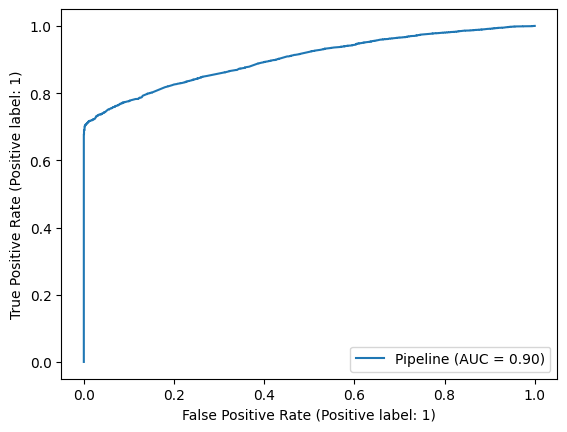

In [ ]:
RocCurveDisplay.from_estimator(random_search_xgb.best_estimator_, X_test, y_test)

The ROC (Receiver Operating Characteristic) curve is a key metric used to evaluate the performance of a classification model, and the AUC (Area Under the Curve) score provides a single value summary of that performance across all classification thresholds. For our XGBoost model, the AUC score of 0.90 is particularly significant. Let's delve into what this means:

1. **Understanding the ROC Curve**: The ROC curve plots the True Positive Rate (TPR, or Recall) against the False Positive Rate (FPR) at various threshold settings. The True Positive Rate is calculated as TP/(TP+FN), which represents the proportion of actual positives correctly identified by the model. The False Positive Rate is calculated as FP/(FP+TN), which indicates the proportion of actual negatives incorrectly classified as positives.
2. **Significance of a 0.90 AUC Score**:
    - **High Discrimination Ability**: An AUC score of 0.90 suggests that the XGBoost model has excellent capability in distinguishing between the classes (Success and Not Success). Specifically, there is a 90% chance that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance. This is close to ideal performance, where an AUC of 1.0 represents a perfect model that classifies all positives and negatives correctly.
    - **Generalization**: High AUC scores often indicate that the model generalizes well to unseen data, assuming the test set is representative of the general population. A model with a high AUC is less likely to be overfitting the training data and is more reliable for practical use.
    - **Model Utility**: In practical terms, a model with a 0.90 AUC can be very effective, particularly in applications where the cost of false positives and false negatives varies significantly. For example, in medical diagnostics or fraud detection, where missing a true positive can have grave consequences, a model with a high AUC is desirable.
3. **Graphical Representation**: Visually, the ROC curve of a model with a 0.90 AUC would rise quickly towards the top-left corner of the plot. This rapid ascent indicates that the model achieves high true positive rates while maintaining low false positive rates across various threshold levels.

Overall, the ROC AUC of 0.90 for our XGBoost model underscores its robustness and effectiveness in classifying outcomes accurately, making it a strong candidate for deployment in scenarios where precise discrimination between classes is crucial.

Confusion Matrix:
 [[1853  619]
 [1018 5442]]
Target
1.0    6460
0.0    2472
Name: count, dtype: int64


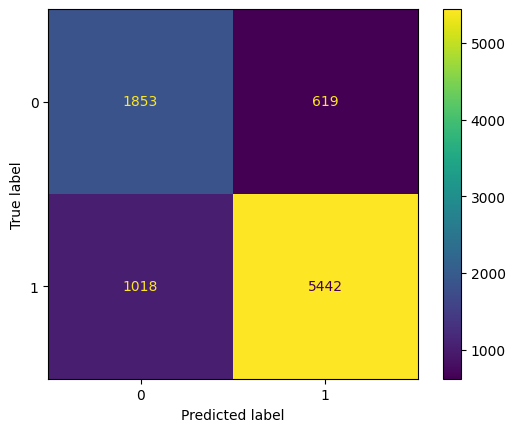

In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm_xgb)

print(y_test.value_counts())
ConfusionMatrixDisplay(cm_xgb).plot();

### 8.6 Neural Network - Model evaluation

In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted_probs = outputs.squeeze()  
            predicted_labels = torch.round(predicted_probs)  
            predictions.extend(predicted_labels.cpu().numpy())  
            true_labels.extend(labels.cpu().numpy())  
    
    # Compute the metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = evaluate_model(model, val_loader, device)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.7985
Precision: 0.9567
Recall: 0.7556
F1 Score: 0.8443


### Neural Network Model Evaluation Summary

The evaluation of the neural network model yields the following metrics:

- **Accuracy**: 0.80
  - This indicates that the model correctly predicts the outcome 81.10% of the time.
- **Precision**: 0.96
  - High precision suggests that the model has a low false positive rate; 96.06% of the positive predictions were correct.
- **Recall**: 0.76
  - The model identifies 76% of all actual positive outcomes.
- **F1 Score**: 0.84
  - The F1 score, which balances precision and recall, is 0.84, indicating a strong overall performance of the model.

These metrics suggest that the model performs well, particularly in terms of precision, but might benefit from improvements in recall to better identify all positive cases. Still XGBoost is our best model, which is why we only tested XGBoost using our test set.

## Part 9. Final Model Interpretation

After evaluating several models, we selected XGBoost as our final model. This decision was based primarily on its superior F1 score, which is critical in balancing the precision and recall, especially in uneven class distributions. XGBoost is well-suited for this kind of problem due to its ability to handle sparse data and its efficiency in computation. Its gradient boosting framework is highly effective in producing a robust model by combining multiple weak learners into a strong learner. 


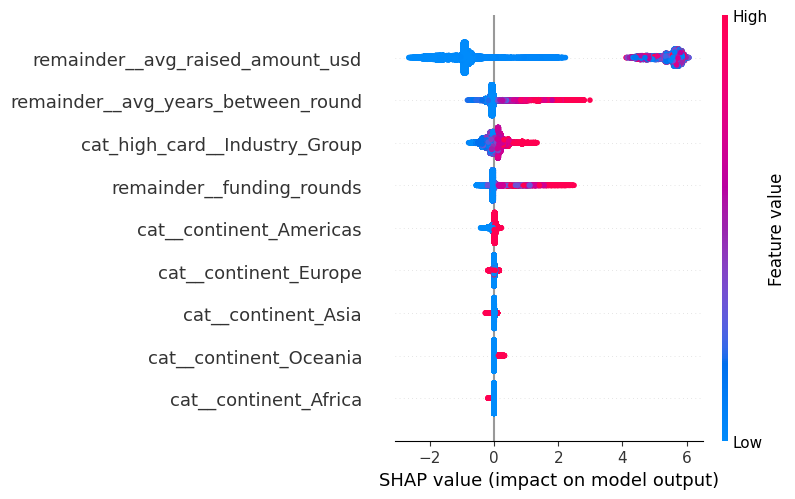

In [ ]:
xgb_best = random_search_xgb.best_estimator_

# Create the SHAP explainer using the best estimator of thye model
explainer = shap.TreeExplainer(xgb_best.named_steps['xgb'])
shap_values = explainer.shap_values(xgb_best.named_steps['preprocessor'].transform(X_train))

shap.summary_plot(shap_values, xgb_best.named_steps['preprocessor'].transform(X_train), feature_names=xgb_best.named_steps['preprocessor'].get_feature_names_out())

### SHAP Summary Plot Explanation for XGBoost Model

The displayed SHAP summary plot originates from an XGBoost model (`xgb_best`), identified as the optimal estimator through a random search cross-validation procedure. This plot elucidates the influence of various features on the model's predictive behavior. Below is an analysis of this visualization:

#### Detailed Features Analysis
- **`remainder_avg_raised_amount_usd`**: This attribute reflects a broad spread of SHAP values, predominantly positive, which suggests it has a substantial and largely beneficial influence on the model’s predictions. Elevated values (represented in red) of the average amount raised in USD are associated with increased outputs from the model.
- **`cat_high_card_Industry_Group`**: Represented as categorical variables, these features denote different industry sectors. Their SHAP value distribution indicates diverse impacts on predictive outcomes, with certain sectors, such as Industry Group 2, showing a more significant effect.
- **Continental Variables**: Features such as `cat_continent_Americas` and `cat_continent_Asia` demonstrate the effect of geographical locations on the model's output. Notably, higher values for the Americas (shown in red) correspond with positive SHAP values, which positively affect the predictions.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


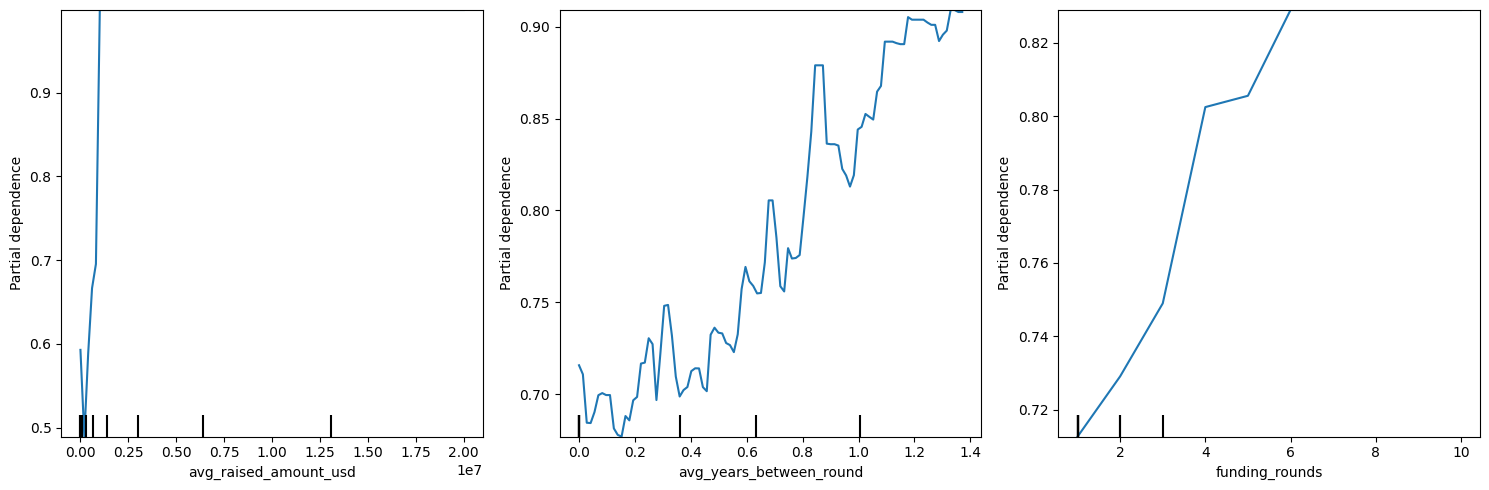

In [ ]:
xgb_best = random_search_xgb.best_estimator_
features_to_plot = ['avg_raised_amount_usd', 'avg_years_between_round', 'funding_rounds']

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

# Plot partial dependence for each feature on separate axes
for i, feature in enumerate(features_to_plot):
    plot_partial_dependence(xgb_best, features=[feature], X=X_train, ax=axs[i])

axs[0].set_xlim([0, 5])  

plt.tight_layout()
plt.show()


## Interpretation of Partial Dependence Plots

### 1. **Average Raised Amount in USD (`avg_raised_amount_usd`)**

- **Behavior**: The plot shows a sharp increase in predictive probability of success at lower values with stabilization at higher amounts.
- **Interpretation**: Initial funding amounts significantly enhance the likelihood of startup success up to a certain point, beyond which additional funding does not improve predictions of success.

### 2. **Average Years Between Funding Rounds (`avg_years_between_round`)**

- **Behavior**: There is a steady increase in the probability of startup success as the average years between funding rounds increase.
- **Interpretation**: Longer intervals between funding rounds are positively correlated with startup success, suggesting that startups that manage sustained operations between rounds are seen as more likely to succeed.

### 3. **Number of Funding Rounds (`funding_rounds`)**

- **Behavior**: The predictive probability of success increases with the number of funding rounds but plateaus after a certain number.
- **Interpretation**: Initial funding rounds are crucial to a startup's success; however, beyond a certain number of rounds, additional funding does not significantly alter the likelihood of success.

### Conclusion

These Partial Dependence Plots provide valuable insights into how key financial metrics influence the predictions of startup success in our model. Understanding these relationships helps in refining model assumptions and can guide strategic decisions for funding and development timelines.


In [ ]:
best_xgb_model = random_search_xgb.best_estimator_

xgb_model = best_xgb_model.named_steps['xgb']

feature_importances = xgb_model.feature_importances_

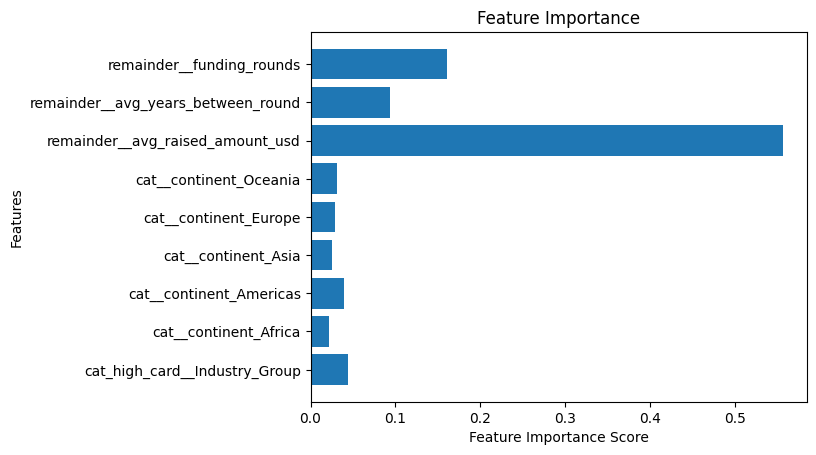

In [ ]:
feature_names = best_xgb_model.named_steps['preprocessor'].get_feature_names_out()

plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


### Feature Importance Analysis

The bar chart displays the relative importance of features in the XGBoost model:

- **`remainder_avg_raised_amount_usd`** is the most significant predictor, indicating that the amount of funding is crucial in driving predictions.
- **`remainder_avg_years_between_round`** and **`remainder_funding_rounds`** suggest that the timing and frequency of funding are also key determinants.
- **`cat_continent_*`** features show the importance varies by continent, with the Americas being most influential.
- **`cat_high_card_Industry_Group`** has the least impact, suggesting industry type is less critical compared to financial metrics.

This analysis highlights that financial and temporal aspects are dominant in influencing the model’s predictions.

### 10. Frontend deployment

To showcase a real life application we creatd an UI for our ML model (app.py) by using Streamlit and our best model XGBoost (xgb_classifier.pkl)

In [ ]:
best_model = random_search_xgb.best_estimator_

with open('xgb_classifier.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model has been saved successfully as xgb_classifier.pkl")


Model has been saved successfully as xgb_classifier.pkl


In [ ]:
!streamlit run app.py --server.port=8080 --browser.serverAddress='0.0.0.0'




  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8080

^C
  Stopping...


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5a7e697c-3af8-4510-a4e4-54669be63340' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>